Install a package to work with ARIMA models.

In [ ]:
!pip install sktime[all_extras]

Load the necessary modules from `scripts` folder.

In [1]:
from google.colab import files
files.upload()

Saving theme_bw.mplstyle to theme_bw.mplstyle
Saving term_paper.xlsx to term_paper.xlsx
Saving technical_indicators.py to technical_indicators.py
Saving main.py to main.py
Saving genetic_algorithm.py to genetic_algorithm.py


{'genetic_algorithm.py': b'from dataclasses import dataclass\nimport gc\n\nfrom main import *\n\n\n@dataclass\nclass GeneticAlgorithmConfig:\n    ell: int = 20\n    k: int = 5\n    mutation_rate: float = 0.1\n    num_epochs: int = 10\n      \n \nclass Individual:\n    def __init__(self):\n        self.name = \'#\' + \'\'.join(map(str, np.random.randint(0,9, size=7).tolist()))\n        self.num_epochs_base = np.random.choice(np.arange(60, 300))\n        self.hidden_size = np.random.choice([2 ** power for power in range(2, 10)])\n        self.num_layers = np.random.choice(np.arange(2, 15))\n        self.learning_rate = round(np.random.random(), 2)\n\n        self.loss = np.inf\n        self.fitness = None\n\n    def __repr__(self):\n        """\n        For convenience only.\n        """\n        string = \'Chromosome \' + self.name + f\' with the loss of {self.loss:.4}\' + f\' and {self.num_epochs_base} epochs:\\n\'\n        string = string + f\'learning_rate = {self.learning_rate:.4}, 

In [2]:
from technical_indicators import *
from main import *
from genetic_algorithm import *

In [3]:
theme_bw = 'theme_bw.mplstyle'
plt.style.use(theme_bw)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

from math import sqrt
import random

import os

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Want to eliminate the randomness.

In [4]:
def seed_everything(seed: int = 77):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

In [5]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:2"

Load the data.

In [6]:
import pandas_datareader as pdr
import datetime as dt

ticker = "SPY"
df = pdr.get_data_yahoo(ticker, dt.datetime(2000, 1,1,1), dt.datetime(2021, 1,1))

Let's look at the time series.

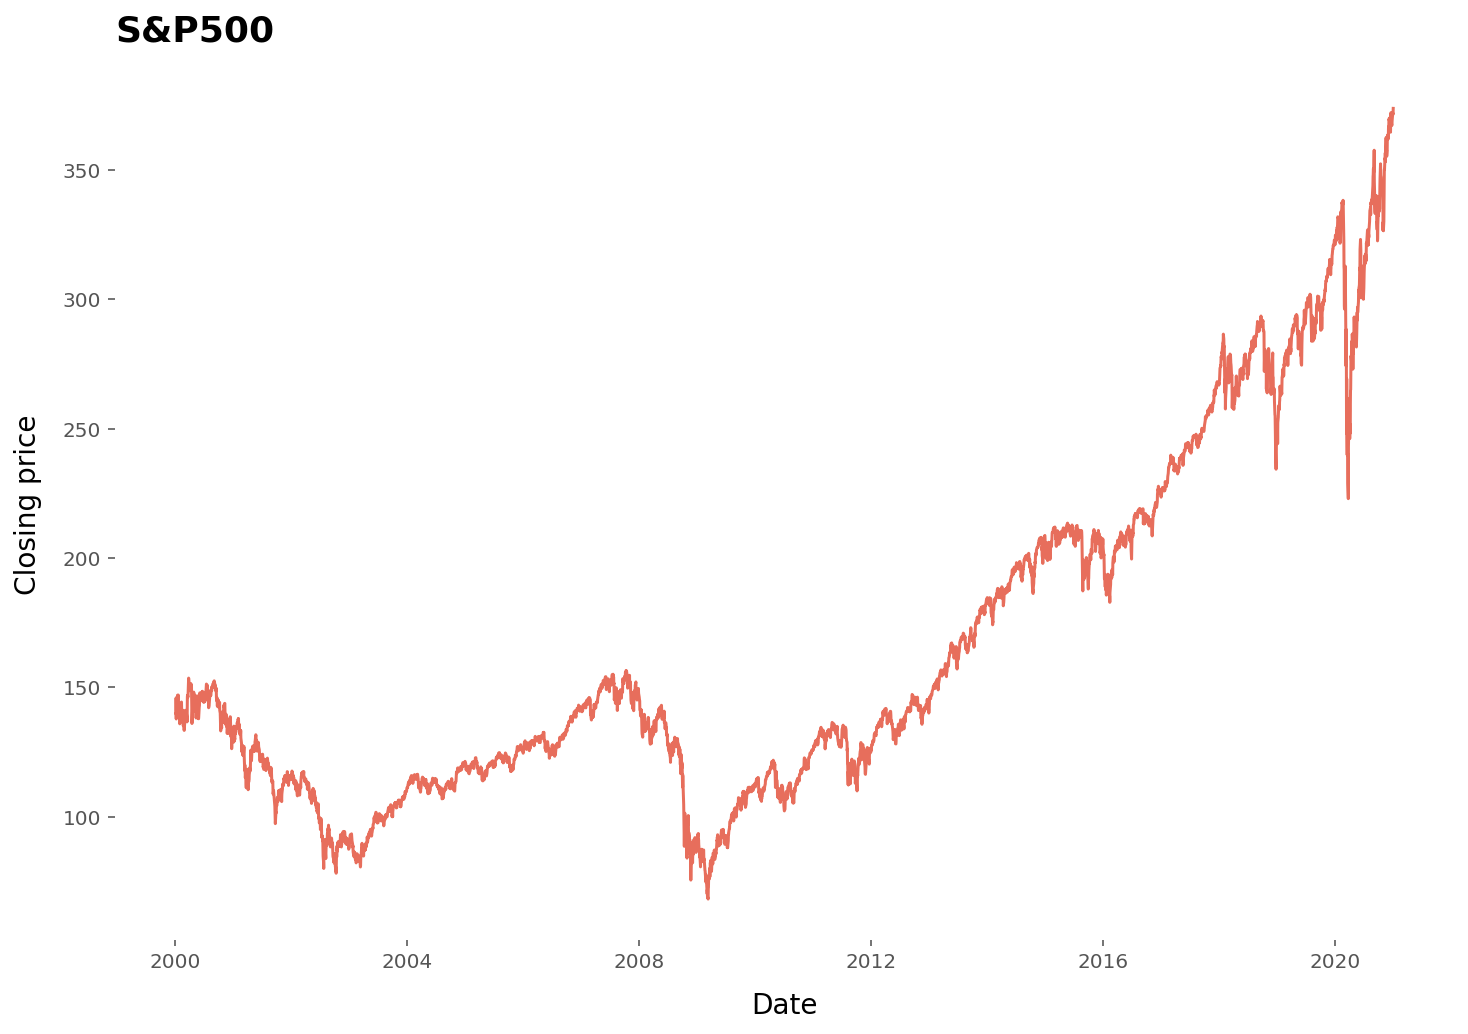

In [7]:
plt.figure(figsize=(12, 8))
plt.title('S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')
plt.plot(df.index, df['Close'], alpha=0.8)
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14)
plt.grid(False);

In [8]:
len(df)

5284

In [9]:
del df['Adj Close']

In [10]:
df.head()

High         Low       Open     Close      Volume
Date                                                              
2000-01-03  148.25000  143.875000  148.25000  145.4375   8164300.0
2000-01-04  144.06250  139.640625  143.53125  139.7500   8089800.0
2000-01-05  141.53125  137.250000  139.93750  140.0000  12177900.0
2000-01-06  141.50000  137.750000  139.62500  137.7500   6227200.0
2000-01-07  145.75000  140.062500  140.31250  145.7500   8066500.0

## ARIMA

In [11]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Use a logarithm to stabilize the variance.

In [ ]:
df_new = df.copy()

In [ ]:
df_new['Log_Close'] = np.log(df_new['Close'])

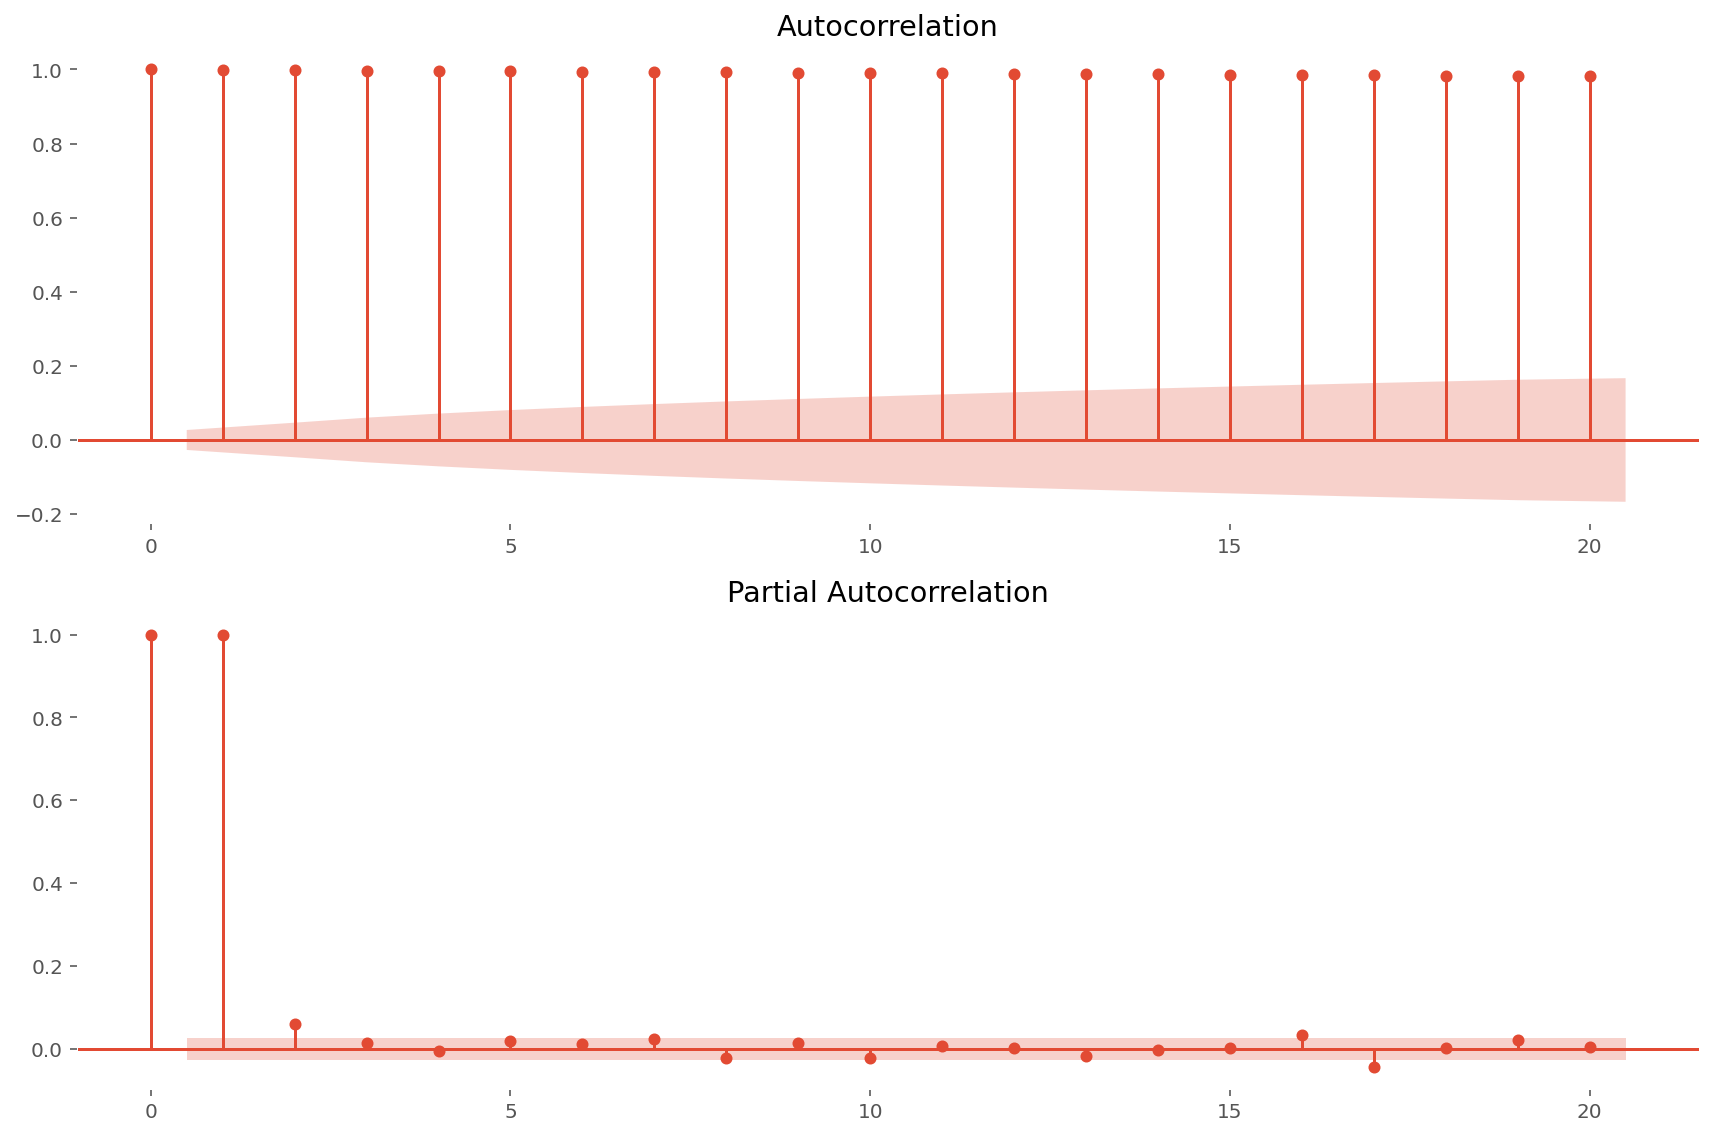

In [ ]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_new['Log_Close'], lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
ax1.grid(False);
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_new['Log_Close'], lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
ax2.grid(False)
fig.tight_layout();

The series are not stationary. Let's use differencing.

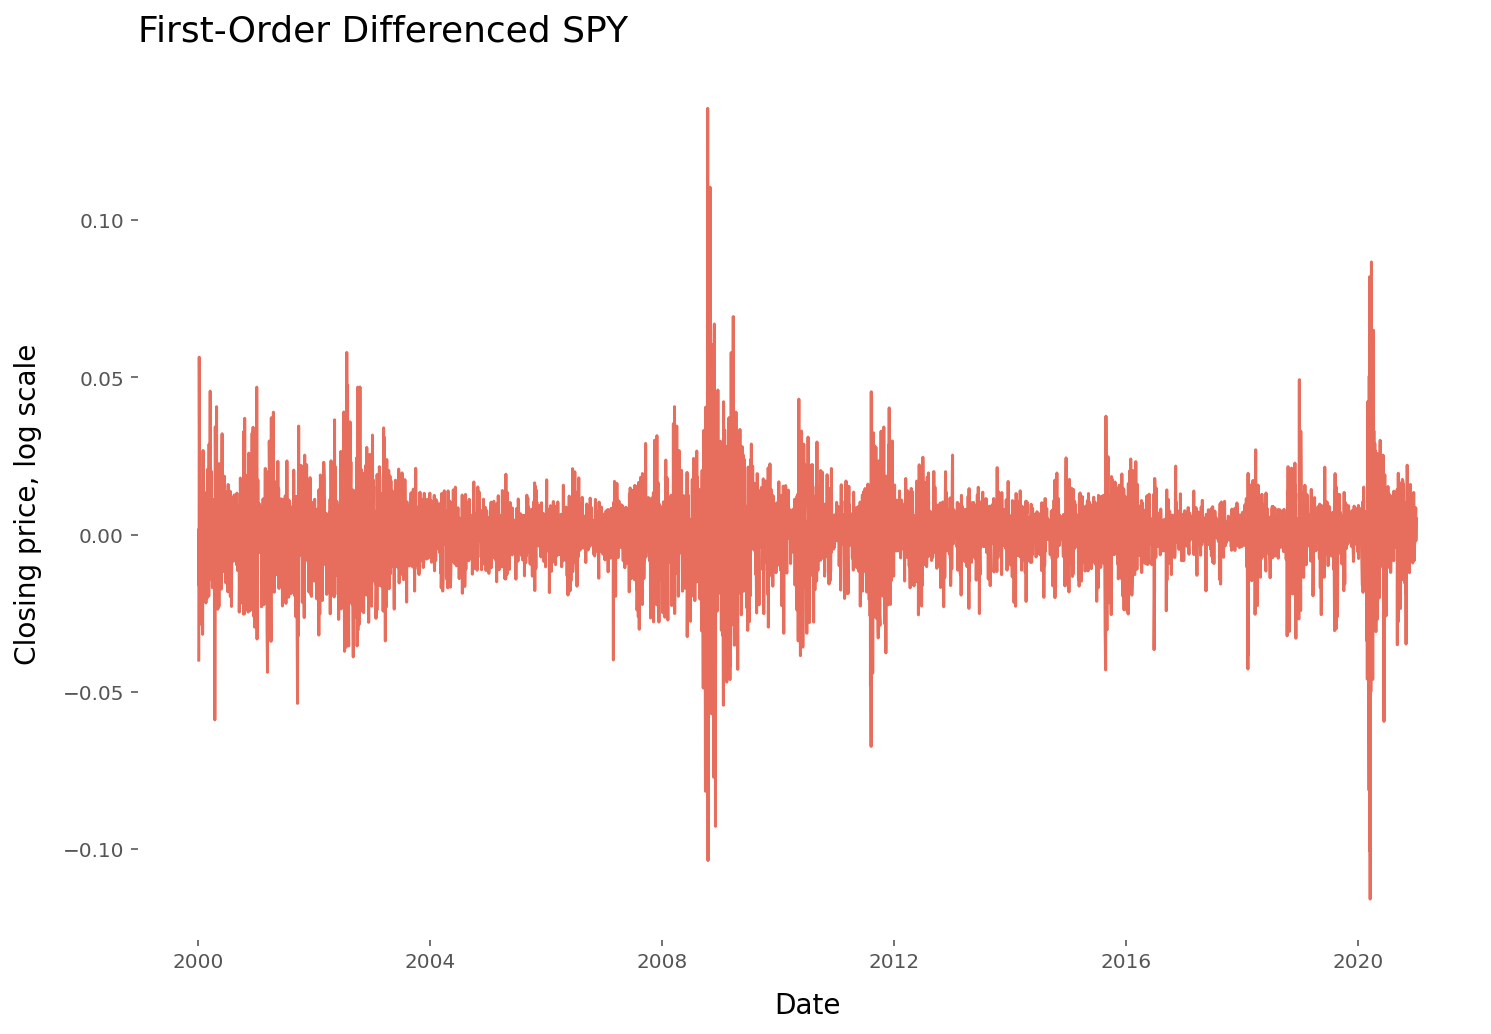

In [ ]:
df_new['Log_Close_Shift_1'] = df_new['Log_Close'].shift()
df_new["Log_Close_Diff_1"] = df_new['Log_Close'] - df_new['Log_Close_Shift_1']
df_new_a = df_new.dropna()

plt.figure(figsize=(12, 8))
plt.title(f'First-Order Differenced {ticker}', pad=14, fontsize=18, loc='left')
plt.plot(df_new_a.index, df_new_a['Log_Close_Diff_1'], alpha=0.8)
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price, log scale', labelpad=10, fontsize=14)
plt.grid(False);

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [ ]:
result = adfuller(df_new_a['Log_Close_Diff_1'])
print(f'ADF Statistic: {result[0]:.6}')
print(f'p-value: {result[1]:.3}')
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.507
p-value: 2.9e-25
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Now it's stationary.

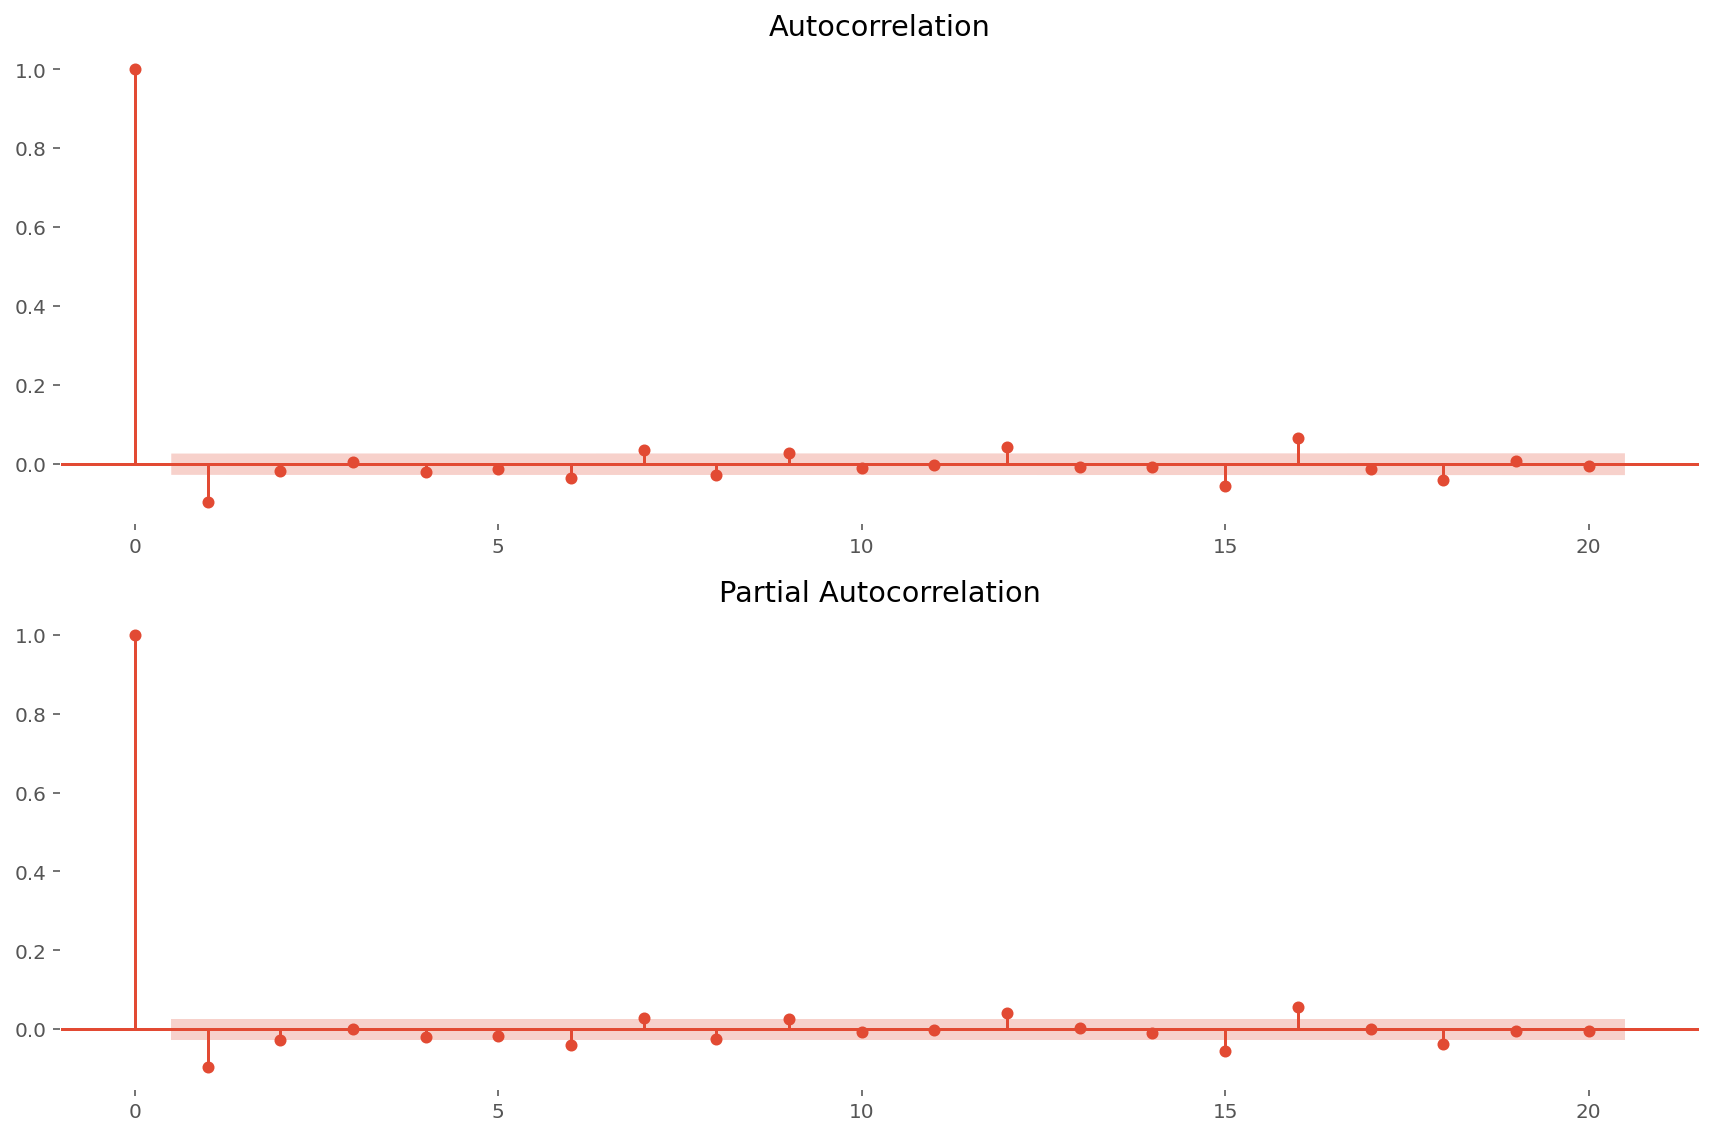

In [ ]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_new_a['Log_Close_Diff_1'], lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
ax1.grid(False)
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_new_a['Log_Close_Diff_1'], lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
ax2.grid(False)
fig.tight_layout();

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon

In [ ]:
train_size = round(0.9 * df.shape[0])
test_size = df.shape[0] - train_size
val_size = round(0.25 * train_size)
train_size = train_size - val_size

In [ ]:
y_train = df_new_a['Close'][:val_size + train_size - 1]
y_test = df_new_a['Close'][val_size + train_size - 1:]

In [ ]:
auto_arima = AutoARIMA(start_p=1, d=1, start_q=0, 
                       max_p=10, max_d=2, max_q=10, 
                       start_P=0, D=0, start_Q=0, 
                       max_P=0, max_D=0, max_Q=0, 
                       suppress_warnings=True, 
                       stepwise=False, n_jobs=-1)

In [ ]:
train_ts_2 = pd.Series(data=y_train.values, index=pd.PeriodIndex(y_train.index, freq='D'))
auto_arima.fit(train_ts_2);

In [ ]:
test_ts_2 = pd.Series(data=y_test.values, index=pd.PeriodIndex(y_test.index, freq='D'))
fh = ForecastingHorizon(test_ts_2.index, is_relative=False)

In [ ]:
y_pred, y_intervals = auto_arima.predict(fh, return_pred_int=True)

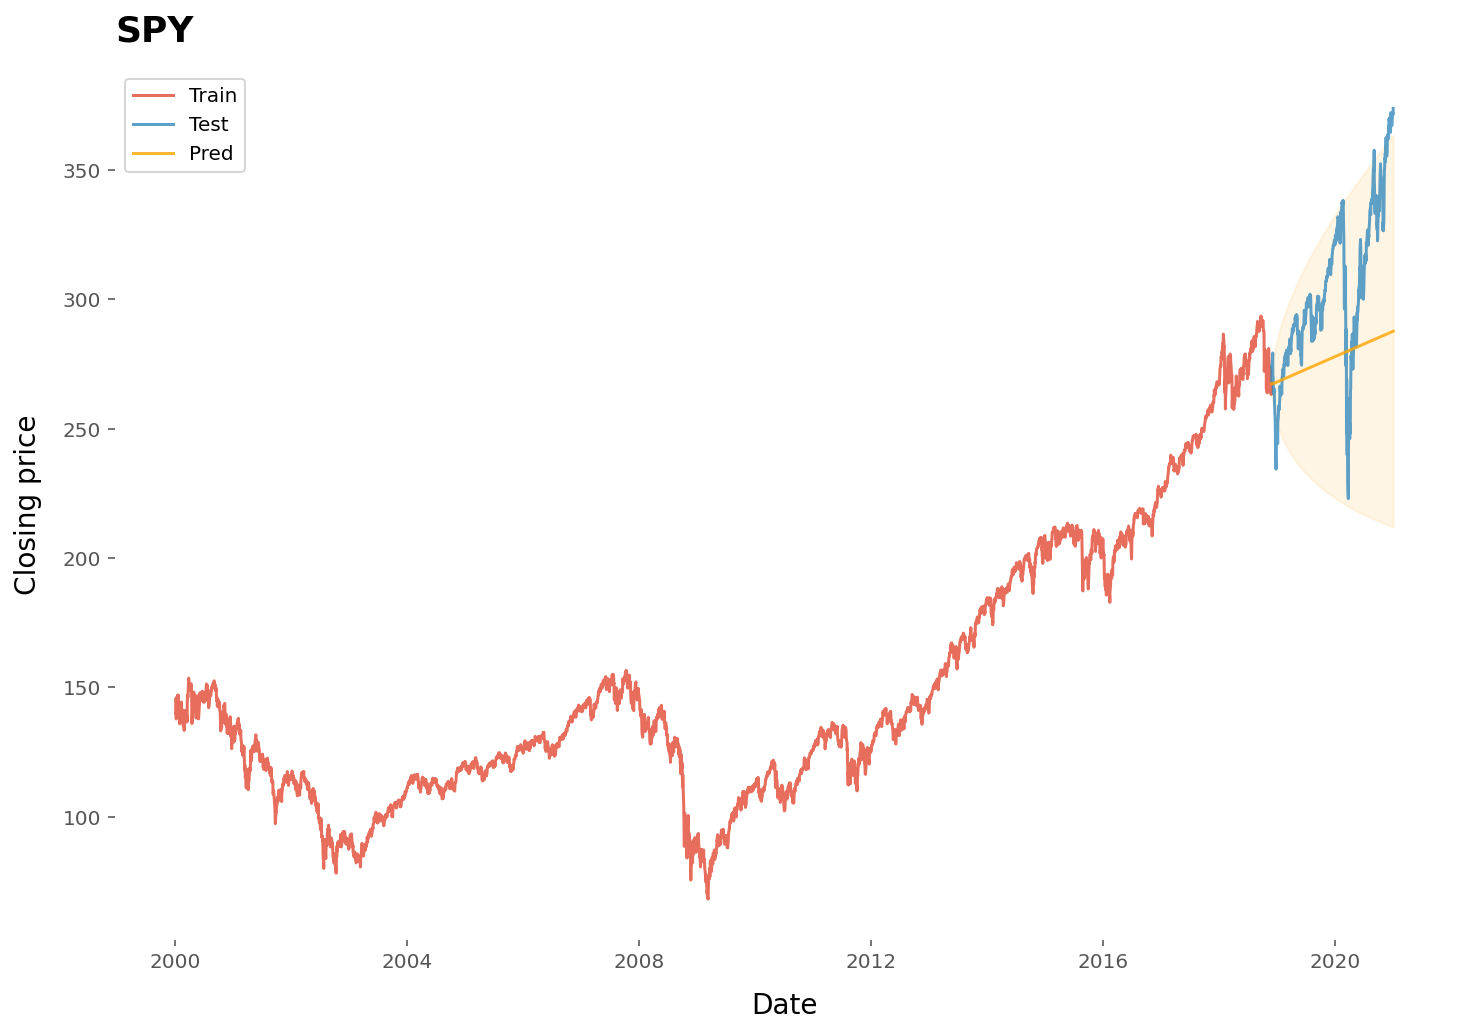

In [ ]:
plt.figure(figsize=(12, 8))
plt.title(f'{ticker}', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index[:train_size+val_size], df['Close'][:train_size+val_size], 
         label='Train', alpha=0.8)

plt.plot(df.index[train_size+val_size:], df['Close'][train_size+val_size:], 
         label='Test', alpha=0.8)

ci_upper = y_intervals['upper'] - y_pred
ci_lower = y_pred - y_intervals['lower']

plt.plot(df.index[train_size+val_size:], y_pred, label='Pred', color='orange', alpha=0.8)

plt.fill_between(df.index[train_size+val_size:], (y_pred-ci_lower), (y_pred+ci_upper), color='orange', alpha=0.1)

plt.grid(False)

plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
print(f'Test RMSE = {np.sqrt(sum((y_pred.values - y_test.values) ** 2)):.6}')
print(f'Test MAE = {sum(np.abs(y_pred.values - y_test.values)):.6}')
smape_test = 100 / len(y_pred.values) * np.sum(2 * np.abs(y_pred.values - y_test.values) / (np.abs(y_pred.values) + np.abs(y_test.values)))
print(f'Test SMAPE = {smape_test:.4}')
print(f'Test R_sq = {r2_score(y_test.values, y_pred.values)}')

Test RMSE = 853.305
Test MAE = 16107.3
Test SMAPE = 10.16
Test R_sq = -0.5162290181162015


In [ ]:
residuals = y_test.values - y_pred.values

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
acorr_ljungbox(residuals, lags=10, return_df=True)

lb_stat      lb_pvalue
1    508.820193  1.145269e-112
2   1004.848676  6.307865e-219
3   1481.852569   0.000000e+00
4   1940.272412   0.000000e+00
5   2383.935125   0.000000e+00
6   2809.888365   0.000000e+00
7   3223.763383   0.000000e+00
8   3617.607250   0.000000e+00
9   3996.892515   0.000000e+00
10  4354.566485   0.000000e+00

In [ ]:
from statsmodels.stats.stattools import jarque_bera

In [ ]:
jarque_bera(residuals)

(0.09916998775930379,
 0.9516242724602298,
 0.023366136486921,
 3.0482060305255505)

## Feature Engineering

In [12]:
import technical_indicators as ti

Добавить еще тех индикаторов.

In [13]:
df['SMA(10)'] = ti.simple_moving_average(df, 10)
df['WMA(10)'] = ti.weighted_moving_average(df, 10)
df['EMA(200)'] = ti.weighted_moving_average(df, 10)

In [14]:
rsi = ti.relative_strength_index(df, 14)
#k_percent, d_percent = ti.stochastic_oscillator(df)
low_bb, high_bb = ti.bollinger_bands(df)
macd, macd_signal, macd_difference = ti.moving_average_convergence_divergence(df)

In [15]:
df['Above_SMA(10)'] = np.where(df['Close'] > df['SMA(10)'], 1, 0)
df['Above_WMA(10)'] = np.where(df['Close'] > df['WMA(10)'], 1, 0)
df['Above_EMA(200)'] = np.where(df['Close'] > df['EMA(200)'], 1, 0)
df['Oversold_RSI(14)'] = np.where(rsi < 30, 1, 0)
df['Overbought_RSI(14)'] = np.where(rsi > 70, 1, 0)
df['Oversold_Bollinger'] = np.where(df['Close'] < low_bb, 1, 0)
df['Overbought_Bollinger'] = np.where(df['Close'] > high_bb, 1, 0)

In [16]:
df.dropna(inplace=True)

In [17]:
df.head()

High        Low  ...  Oversold_Bollinger  Overbought_Bollinger
Date                              ...                                          
2000-01-14  147.46875  145.96875  ...                   0                     0
2000-01-18  146.62500  145.18750  ...                   0                     0
2000-01-19  147.00000  145.00000  ...                   0                     0
2000-01-20  146.96875  143.81250  ...                   0                     0
2000-01-21  145.50000  144.06250  ...                   0                     0

[5 rows x 15 columns]

In [18]:
df.describe()

High          Low  ...  Oversold_Bollinger  Overbought_Bollinger
count  5275.000000  5275.000000  ...         5275.000000           5275.000000
mean    166.467818   164.413143  ...            0.068626              0.062749
std      67.486134    66.997448  ...            0.252840              0.242534
min      70.000000    67.099998  ...            0.000000              0.000000
25%     117.475002   115.655003  ...            0.000000              0.000000
50%     139.660004   137.699997  ...            0.000000              0.000000
75%     208.235001   206.065002  ...            0.000000              0.000000
max     378.459991   371.570007  ...            1.000000              1.000000

[8 rows x 15 columns]

In [19]:
buy_signal_rsi = np.where(df['Oversold_RSI(14)'].to_numpy() == 1, df['Close'], np.nan)
sell_signal_rsi = np.where(df['Overbought_RSI(14)'].to_numpy() == 1, df['Close'], np.nan)
buy_signal_bb = np.where(df['Oversold_Bollinger'].to_numpy() == 1, df['Close'], np.nan)
sell_signal_bb = np.where(df['Overbought_Bollinger'].to_numpy() == 1, df['Close'], np.nan)

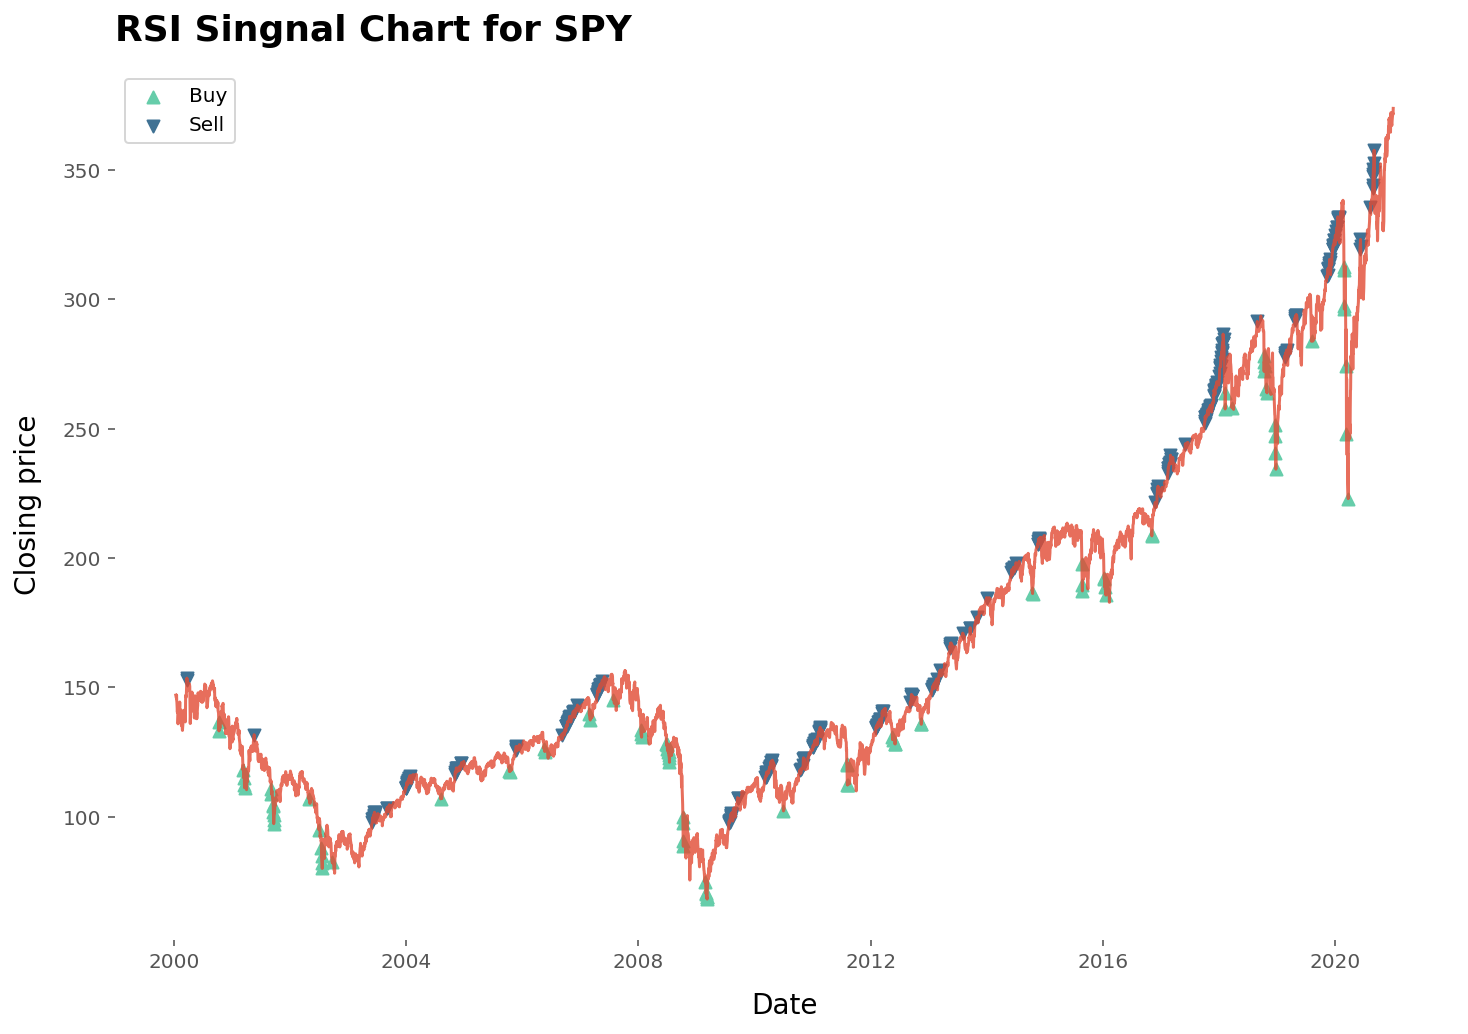

In [20]:
plt.figure(figsize=(12, 8))
plt.title(f'RSI Singnal Chart for {ticker}', pad=14, fontsize=18, loc='left', fontweight='bold')
plt.plot(df.index, df['Close'], alpha=0.8)
plt.scatter(df.index, buy_signal_rsi, label='Buy', marker='^', color='#66cdaa')
plt.scatter(df.index, sell_signal_rsi, label='Sell', marker='v', color='#407294')
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14)
plt.grid(False)
plt.legend();

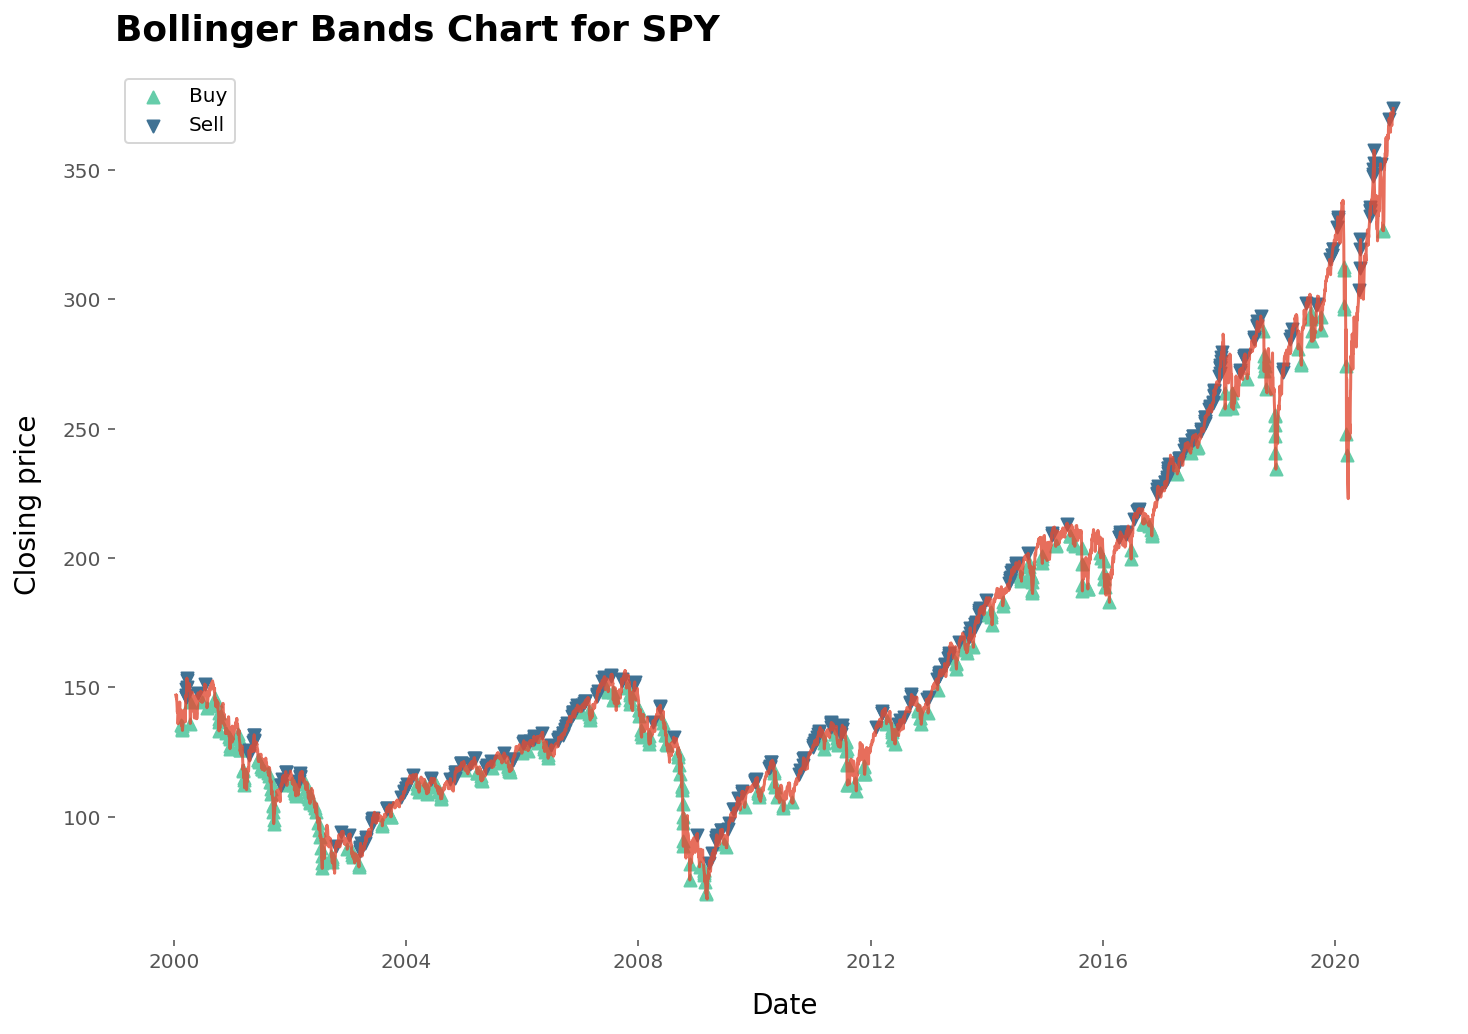

In [21]:
plt.figure(figsize=(12, 8))
plt.title(f'Bollinger Bands Chart for {ticker}', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], alpha=0.8)
plt.scatter(df.index, buy_signal_bb, label='Buy', marker='^', color='#66cdaa')
plt.scatter(df.index, sell_signal_bb, label='Sell', marker='v', color='#407294')

plt.grid(False)
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14)
plt.legend();

Split the data on training, validation and test datasets.

## Preprocess Data

In [22]:
train_size = round(0.9 * df.shape[0])
test_size = df.shape[0] - train_size
val_size = round(0.25 * train_size)
train_size = train_size - val_size

### Without Technical Indicators

In [23]:
data = df['Close'].to_numpy()

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler_without = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_without.fit_transform(data.reshape(-1, 1))).reshape(1, -1).type(torch.Tensor)

In [25]:
window_size = 15

batch_windows = data_preproc.unfold(dimension=-1, size=window_size, step=1).reshape(-1, window_size, 1)
    
X_train_without = batch_windows[:val_size + train_size, :-1, :]
X_test_without = batch_windows[val_size + train_size:, :-1]

# Need predict the next value 
y_train_without = batch_windows[:val_size + train_size, -1, :]
y_test_without = batch_windows[val_size + train_size:, -1, :]

### With Technical Indicators

In [26]:
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'SMA(10)', 'WMA(10)',
       'EMA(200)', 'Above_SMA(10)', 'Above_WMA(10)', 'Above_EMA(200)',
       'Oversold_RSI(14)', 'Overbought_RSI(14)', 'Oversold_Bollinger',
       'Overbought_Bollinger'],
      dtype='object')

In [27]:
columns_titles = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA(10)', 'WMA(10)',
                  'EMA(200)', 'Oversold_RSI(14)', 'Overbought_RSI(14)',
                  'Oversold_Bollinger', 'Overbought_Bollinger']
df=df.reindex(columns=columns_titles)

In [28]:
df.head()

Close       High  ...  Oversold_Bollinger  Overbought_Bollinger
Date                              ...                                          
2000-01-14  146.96875  147.46875  ...                   0                     0
2000-01-18  145.81250  146.62500  ...                   0                     0
2000-01-19  147.00000  147.00000  ...                   0                     0
2000-01-20  144.75000  146.96875  ...                   0                     0
2000-01-21  144.43750  145.50000  ...                   0                     0

[5 rows x 12 columns]

In [29]:
scaler_with = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_with.fit_transform(df)).type(torch.Tensor)

In [30]:
data_preproc_t = data_preproc.transpose(-2, -1)
data_preproc_t

tensor([[-0.4842, -0.4918, -0.4840,  ...,  0.9842,  0.9876,  1.0000],
        [-0.4977, -0.5032, -0.5007,  ...,  0.9711,  0.9652,  0.9754],
        [-0.4819, -0.4871, -0.4883,  ...,  0.9951,  1.0000,  0.9978],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000,  1.0000]])

In [31]:
windows = []

for i in range(data_preproc.shape[1]):
    windows.append(data_preproc_t.unfold(dimension=-1, size=window_size, step=1)[i].reshape(-1, window_size, 1))

In [32]:
batch_windows = torch.cat((windows), dim=2)

In [33]:
X_train_with = batch_windows[:val_size + train_size, :-1, :]
X_test_with = batch_windows[val_size + train_size:, :-1]

y_train_with = y_train_without
y_test_with = y_test_without

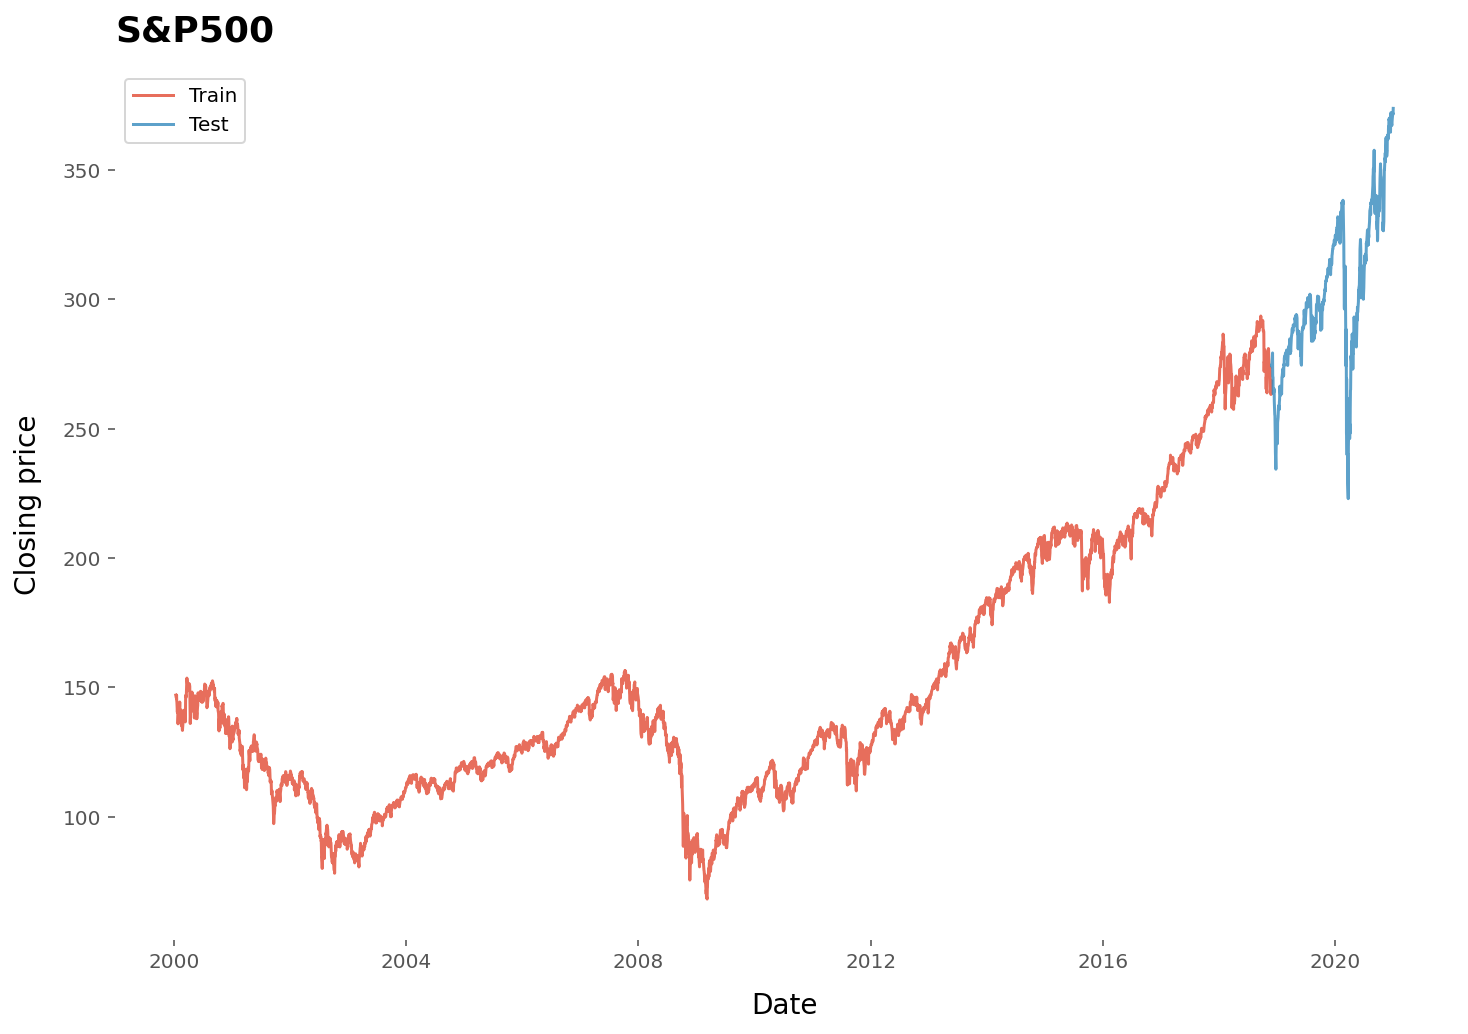

In [34]:
plt.figure(figsize=(12, 8))
plt.title('S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index[:train_size+val_size], 
         df['Close'][:train_size+val_size], 
         label='Train', alpha=0.8)

plt.plot(df.index[train_size+val_size:], 
         df['Close'][train_size+val_size:], 
         label='Test', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

## Models

In [35]:
def get_predictions(model, scaler, X_train, y_train, X_test, y_test):
    model.eval()
    y_pred_train = model(X_train.to(device))
    y_pred_test = model(X_test.to(device))

    y_pred_train = scaler.inverse_transform(y_pred_train.cpu().detach().numpy())
    y_train = scaler.inverse_transform(y_train.cpu().detach().numpy())
    
    y_pred_test = scaler.inverse_transform(y_pred_test.cpu().detach().numpy())
    y_test = scaler.inverse_transform(y_test.cpu().detach().numpy())

    return y_pred_train, y_train, y_pred_test, y_test

In [36]:
from sklearn.metrics import r2_score

In [37]:
def eval_losses(y_pred_train, y_true_train, y_pred_test, y_true_test):
    print(f'Train RMSE = {np.sqrt(sum((y_pred_train - y_true_train) ** 2))[0]:.5}')
    print(f'Train MAE = {sum(np.abs(y_pred_train - y_true_train))[0]:.5}')
    smape_train = 100 / len(y_pred_train) * np.sum(2 * np.abs(y_pred_train - y_true_train) / (np.abs(y_pred_train) + np.abs(y_true_train)))
    print(f'Train SMAPE = {smape_train:.5}\n')


    print(f'Test RMSE = {np.sqrt(sum((y_pred_test - y_true_test) ** 2))[0]:.5}')
    print(f'Test MAE = {sum(np.abs(y_pred_test - y_true_test))[0]:.7}')
    smape_test = 100 / len(y_pred_test) * np.sum(2 * np.abs(y_pred_test - y_true_test) / (np.abs(y_pred_test) + np.abs(y_true_test)))
    print(f'Test SMAPE = {smape_test:.5}')

    print(f'R_sq = {r2_score(y_true_test, y_pred_test)}')

In [38]:
class RMSELoss(nn.Module):
    def __init__(self, reduction):
        super().__init__()
        self.mse = nn.MSELoss(reduction=reduction)
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [39]:
criterion = RMSELoss(reduction='mean')

### LSTM

#### Without Technical Indicators

In [40]:
seed_everything()
lstm_model = LSTM()
lstm_model.to(device)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [41]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

Epoch: 100


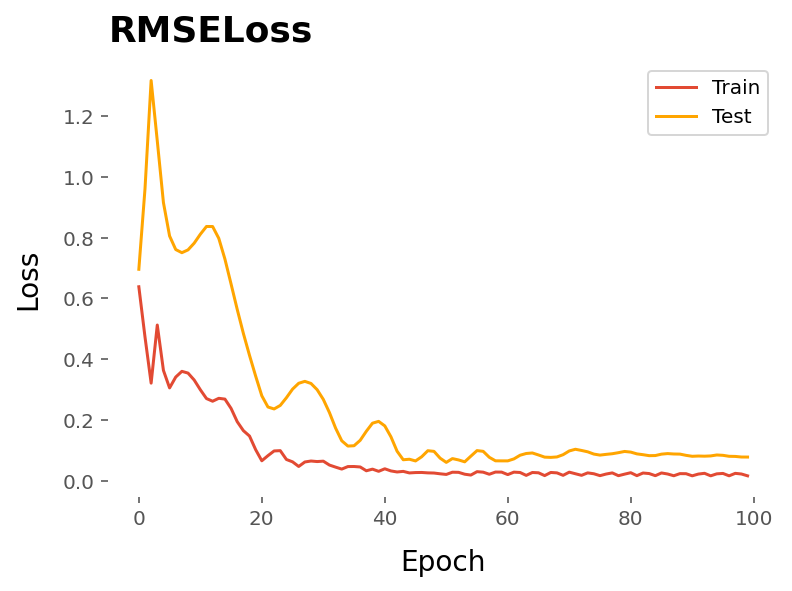

Train loss: 0.01559
Test loss: 0.07739


In [42]:
seed_everything()
train_loss_lstm_without, test_loss_lstm_without = \
    train(lstm_model, criterion, optimizer, device, X_train_without, y_train_without, 
           X_test_without, y_test_without, n_epochs=100)

In [43]:
y_pred_train_lstm_without, y_train_lstm_without, y_pred_test_lstm_without, y_test_lstm_without = \
    get_predictions(lstm_model, scaler_without, X_train_without, y_train_without, X_test_without, y_test_without)

In [44]:
eval_losses(y_pred_train_lstm_without, y_train_lstm_without, 
            y_pred_test_lstm_without, y_test_lstm_without)

Train RMSE = 240.81
Train MAE = 1.3962e+04
Train SMAPE = 2.2901

Test RMSE = 267.99
Test MAE = 4395.734
Test SMAPE = 2.7403
R_sq = 0.8432878109779823


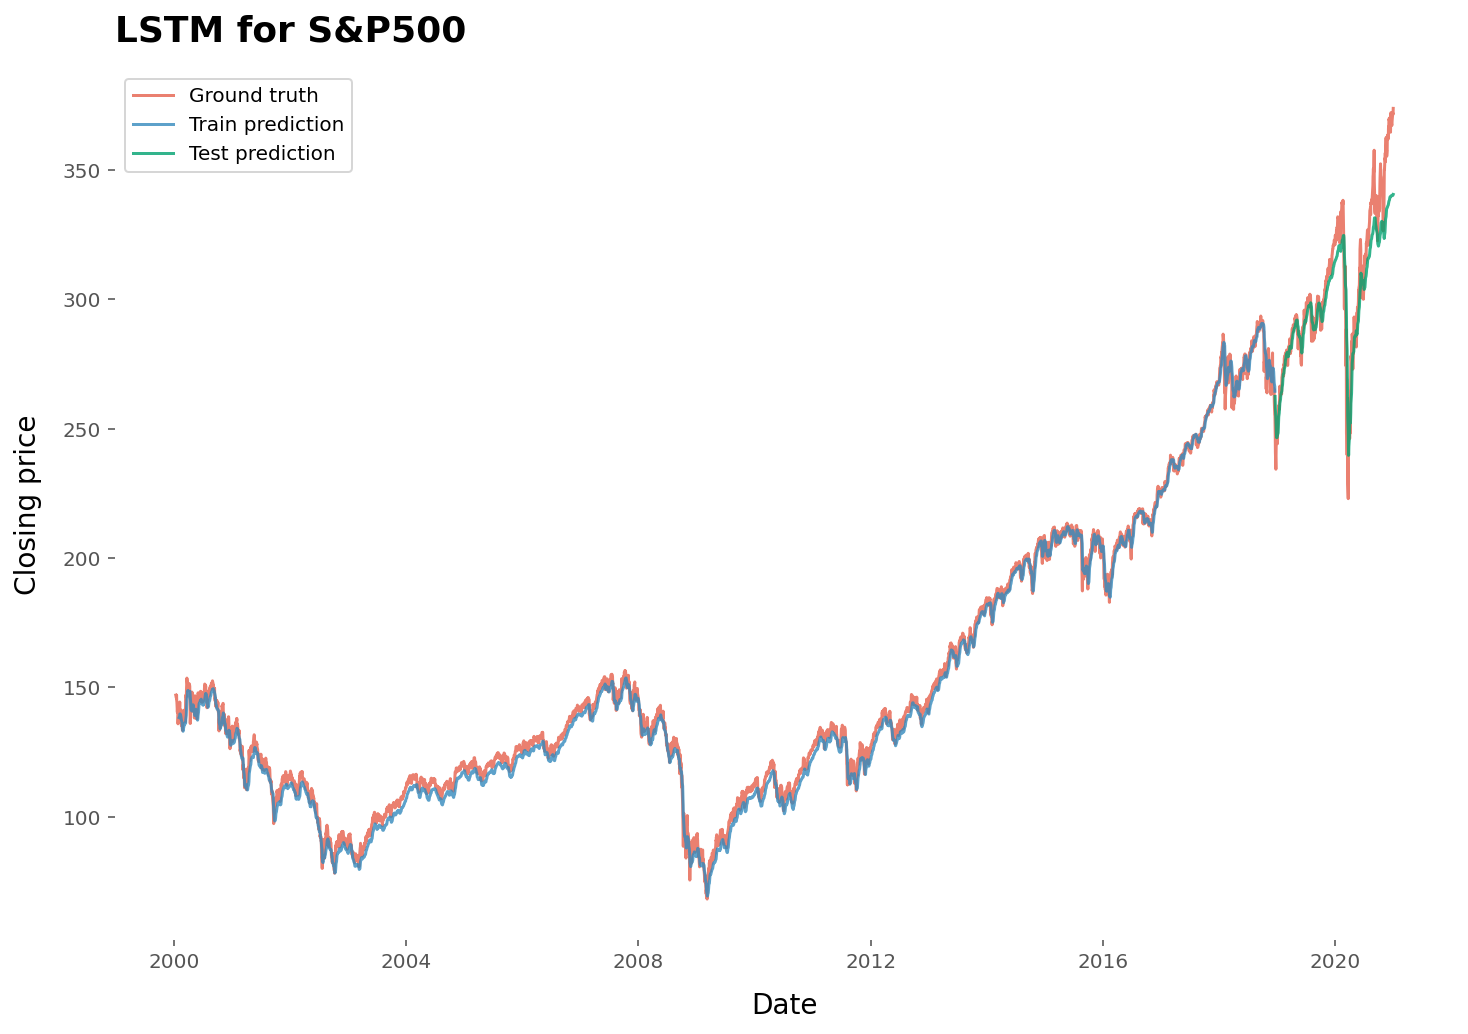

In [45]:
plt.figure(figsize=(12, 8))
plt.title(f'LSTM for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth', alpha=0.7)
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_lstm_without.ravel(), label='Train prediction', alpha=0.8)
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_lstm_without.ravel(), label='Test prediction', color='#00A170', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### With Technical Indicators

In [46]:
seed_everything()
lstm_model = LSTM(input_size=X_train_with.shape[2])
lstm_model.to(device)

LSTM(
  (lstm): LSTM(12, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [47]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

Epoch: 100


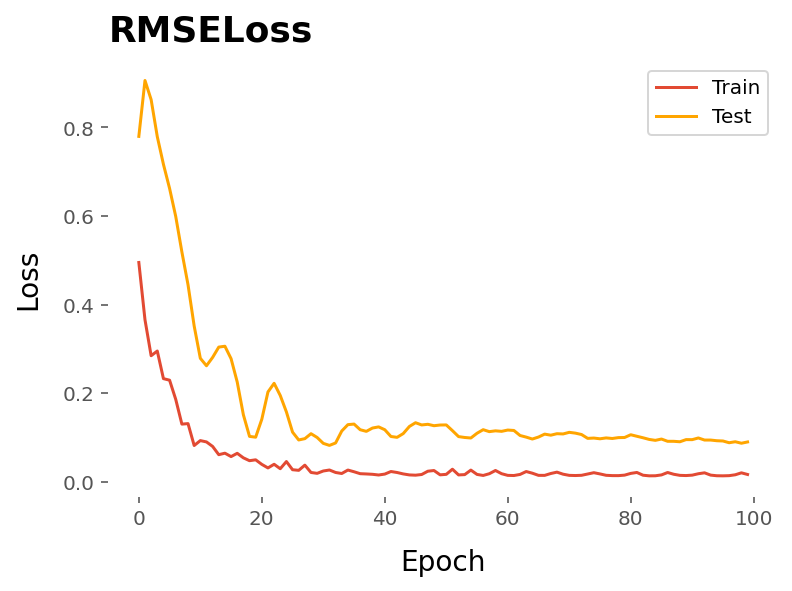

Train loss: 0.01676
Test loss: 0.09018


In [48]:
seed_everything()
train_loss_lstm_with, test_loss_lstm_with = \
    train(lstm_model, criterion, optimizer, device, X_train_with, y_train_without,
          X_test_with, y_test_without, n_epochs=100)

In [49]:
y_pred_train_lstm_with, y_train_lstm_with, y_pred_test_lstm_with, y_test_lstm_with = \
    get_predictions(lstm_model, scaler_without, X_train_with, y_train_with, X_test_with, y_test_with)

In [50]:
eval_losses(y_pred_train_lstm_with, y_train_lstm_with, y_pred_test_lstm_with, 
            y_test_lstm_with)

Train RMSE = 155.32
Train MAE = 7830.4
Train SMAPE = 1.2245

Test RMSE = 312.29
Test MAE = 5116.638
Test SMAPE = 3.1755
R_sq = 0.7872051458290008


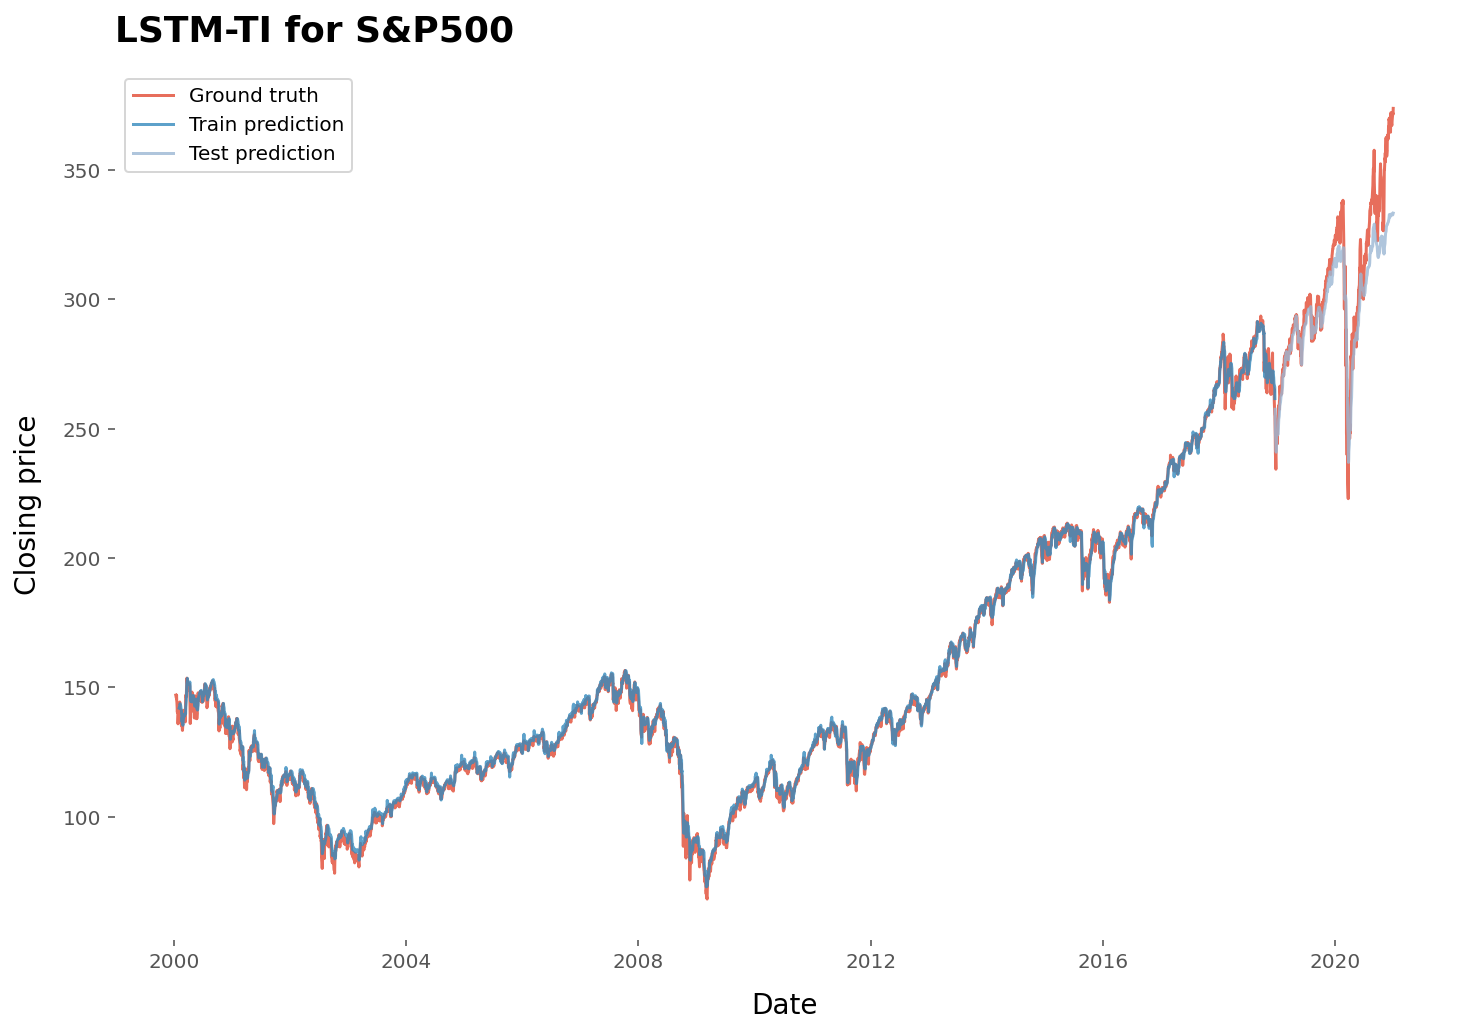

In [51]:
plt.figure(figsize=(12, 8))
plt.title(f'LSTM-TI for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth', alpha=0.8)
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_lstm_with.ravel(), label='Train prediction', alpha=0.8)
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_lstm_with.ravel(), label='Test prediction', color='#9BB7D4', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

### Gated Recurrent Units

#### Without Technical Indicators

In [52]:
seed_everything()
gru_model = GRU()
gru_model.to(device)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [53]:
optimizer = optim.Adam(gru_model.parameters(), lr=0.01)

Epoch: 100


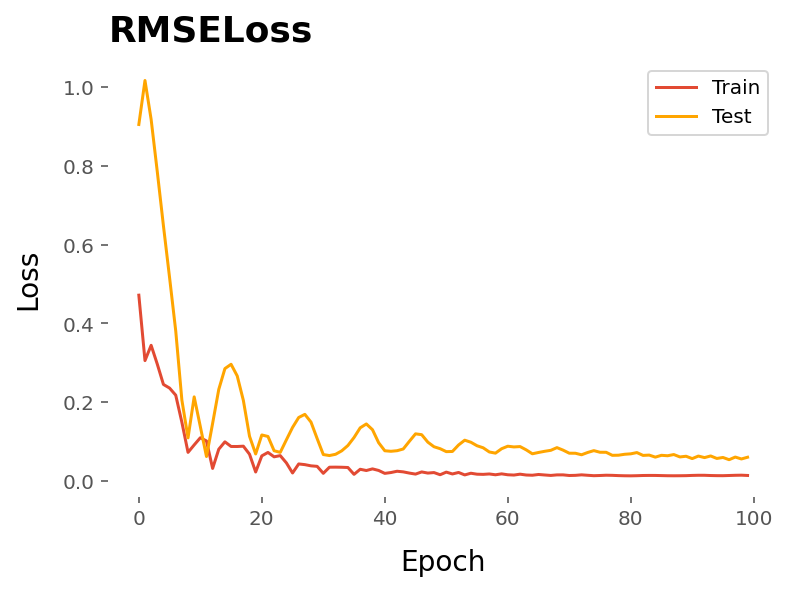

Train loss: 0.01424
Test loss: 0.06049


In [54]:
seed_everything()
train_loss_gru_without, test_loss_gru_without = \
    train(gru_model, criterion, optimizer, device, X_train_without, y_train_without, X_test_without, 
          y_test_without, n_epochs=100)

In [55]:
y_pred_train_gru_without, y_train_gru_without, y_pred_test_gru_without, y_test_gru_without = \
    get_predictions(gru_model, scaler_without, X_train_without, y_train_without, 
                    X_test_without, y_test_without)

In [56]:
eval_losses(y_pred_train_gru_without, y_train_gru_without, y_pred_test_gru_without, 
            y_test_gru_without)

Train RMSE = 145.35
Train MAE = 7264.4
Train SMAPE = 1.1402

Test RMSE = 209.47
Test MAE = 3797.83
Test SMAPE = 2.3803
R_sq = 0.9042575719447921


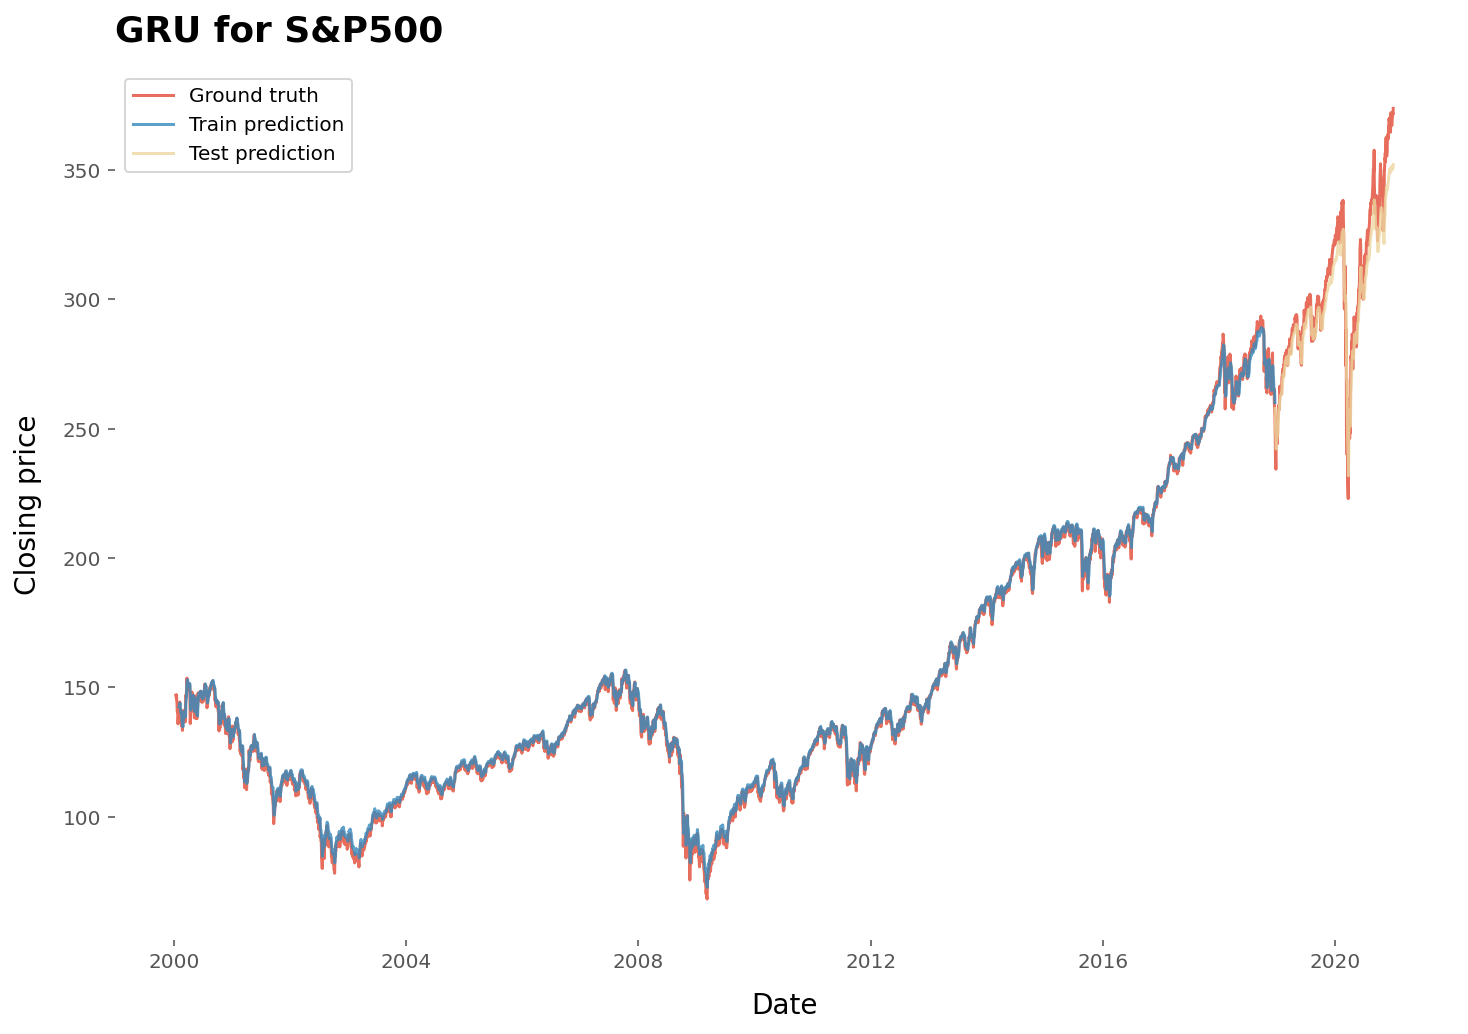

In [57]:
plt.figure(figsize=(12, 8))
plt.title(f'GRU for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth', alpha=0.8)
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_gru_without.ravel(), label='Train prediction', alpha=0.8)
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_gru_without.ravel(), label='Test prediction', color='#EDD59E', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### With Technical Indicators

In [58]:
seed_everything()
gru_model = GRU(input_size=X_train_with.shape[2])
gru_model.to(device)

GRU(
  (gru): GRU(12, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [59]:
optimizer = optim.Adam(gru_model.parameters(), lr=0.01)

Epoch: 100


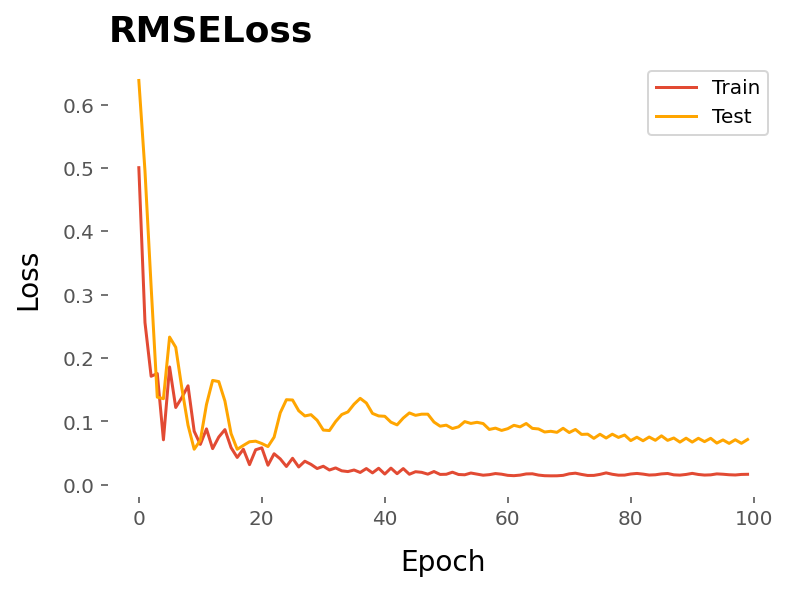

Train loss: 0.01654
Test loss: 0.07147


In [60]:
seed_everything()
train_loss_gru_with, test_loss_gru_with = \
    train(gru_model, criterion, optimizer, device, X_train_with, y_train_with, 
          X_test_with, y_test_with, n_epochs=100)

In [61]:
y_pred_train_gru_with, y_train_gru_with, y_pred_test_gru_with, y_test_gru_with = \
    get_predictions(gru_model, scaler_without, X_train_with, y_train_with, X_test_with, y_test_with)

In [62]:
eval_losses(y_pred_train_gru_with, y_train_gru_with, y_pred_test_gru_with, 
            y_test_gru_with)

Train RMSE = 171.21
Train MAE = 9220.0
Train SMAPE = 1.4793

Test RMSE = 247.47
Test MAE = 4297.263
Test SMAPE = 2.6788
R_sq = 0.8663731352055268


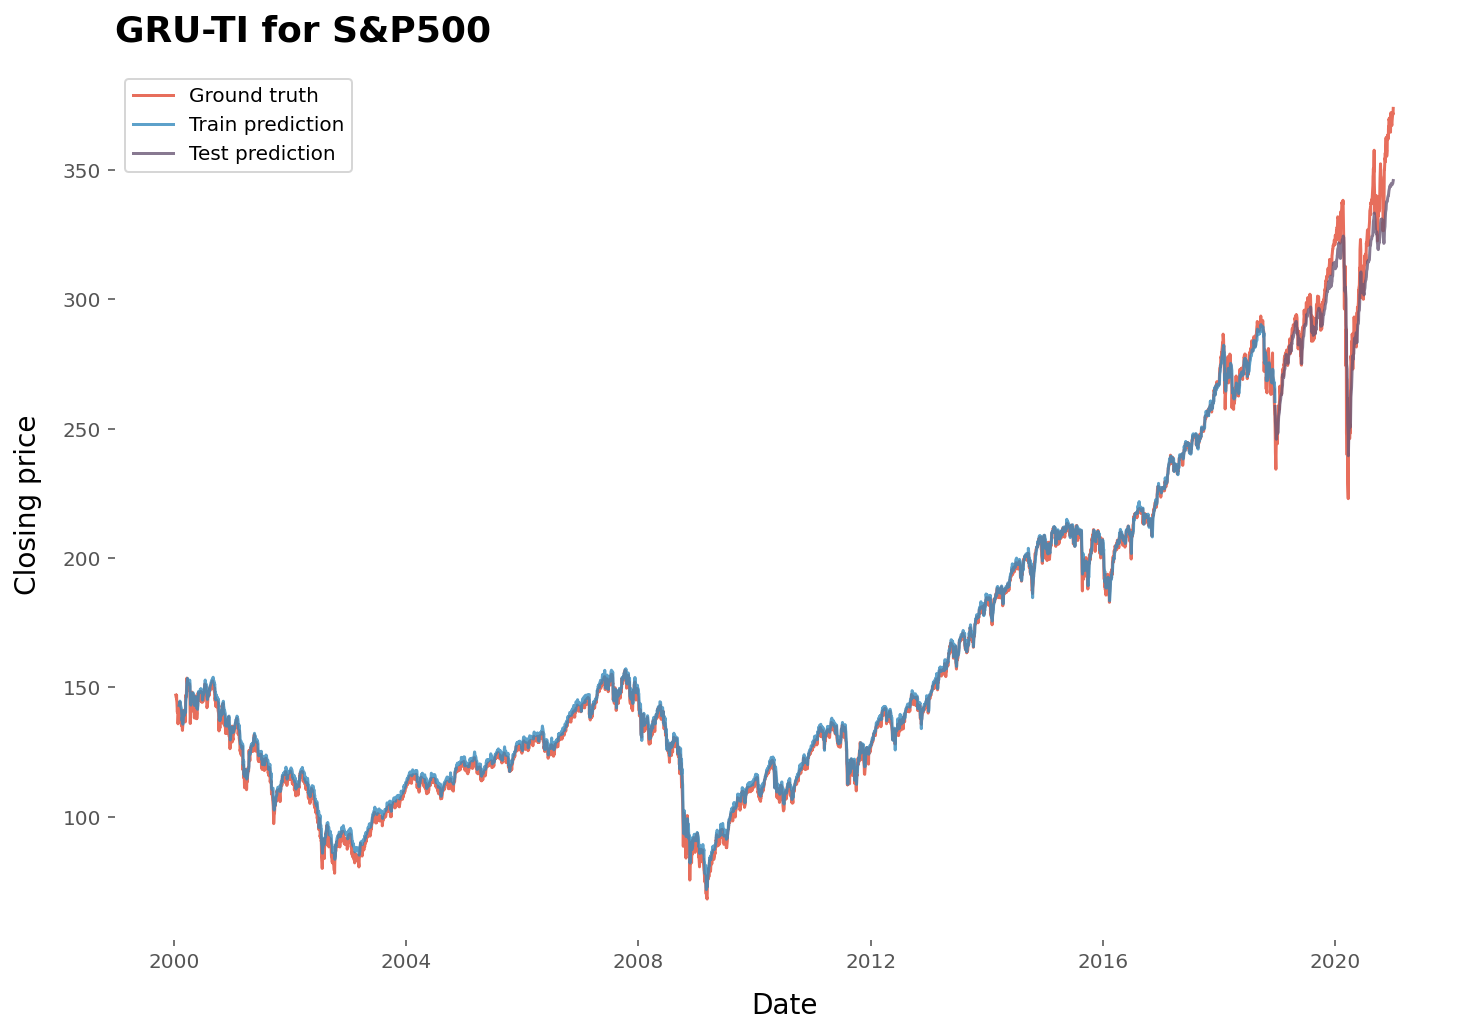

In [63]:
plt.figure(figsize=(12, 8))
plt.title(f'GRU-TI for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth', alpha=0.8)
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_gru_with.ravel(), label='Train prediction', alpha=0.8)
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_gru_with.ravel(), label='Test prediction', color='#6B5876', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### Comparison

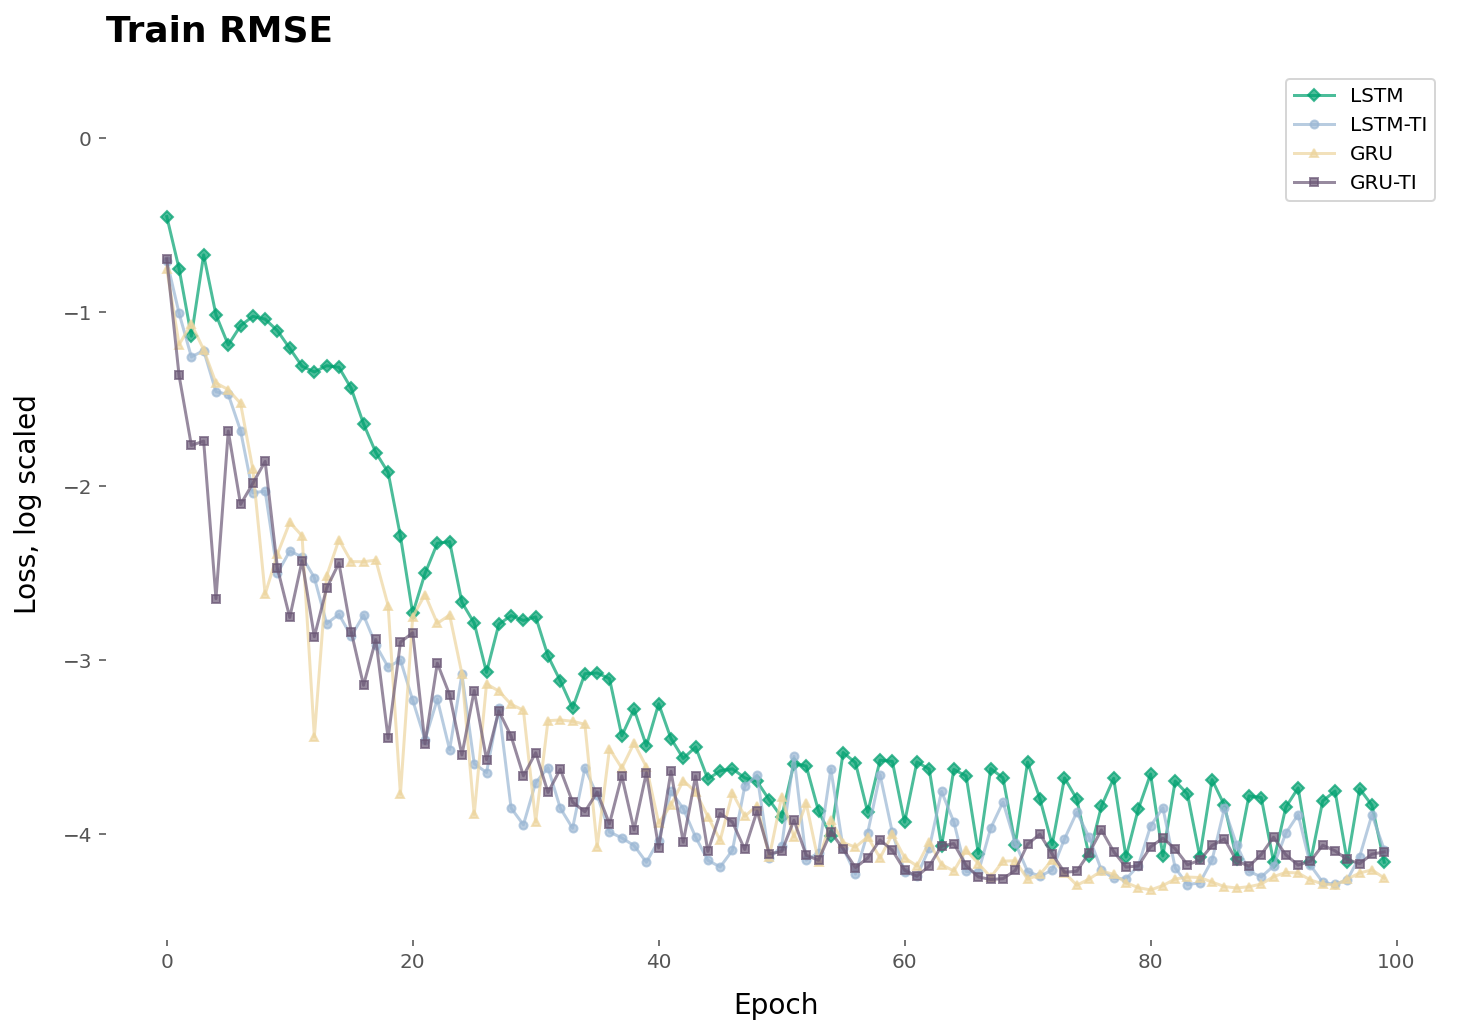

In [64]:
plt.figure(figsize=(12, 8))
plt.title('Train RMSE', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(np.log(train_loss_lstm_without), marker='D', markersize=4, label='LSTM', alpha=0.7, color='#00A170')
plt.plot(np.log(train_loss_lstm_with), marker='o', markersize=4, label='LSTM-TI', alpha=0.7, color='#9BB7D4')
plt.plot(np.log(train_loss_gru_without), marker='^', markersize=4, label='GRU', alpha=0.7, color='#EDD59E')
plt.plot(np.log(train_loss_gru_with), marker='s', markersize=4, label='GRU-TI', alpha=0.7, color='#6B5876')

plt.grid(False)
plt.legend()

plt.ylim(-4.6, 0.4)

plt.ylabel('Loss, log scaled', labelpad=10, fontsize=14)
plt.xlabel('Epoch', labelpad=10, fontsize=14);

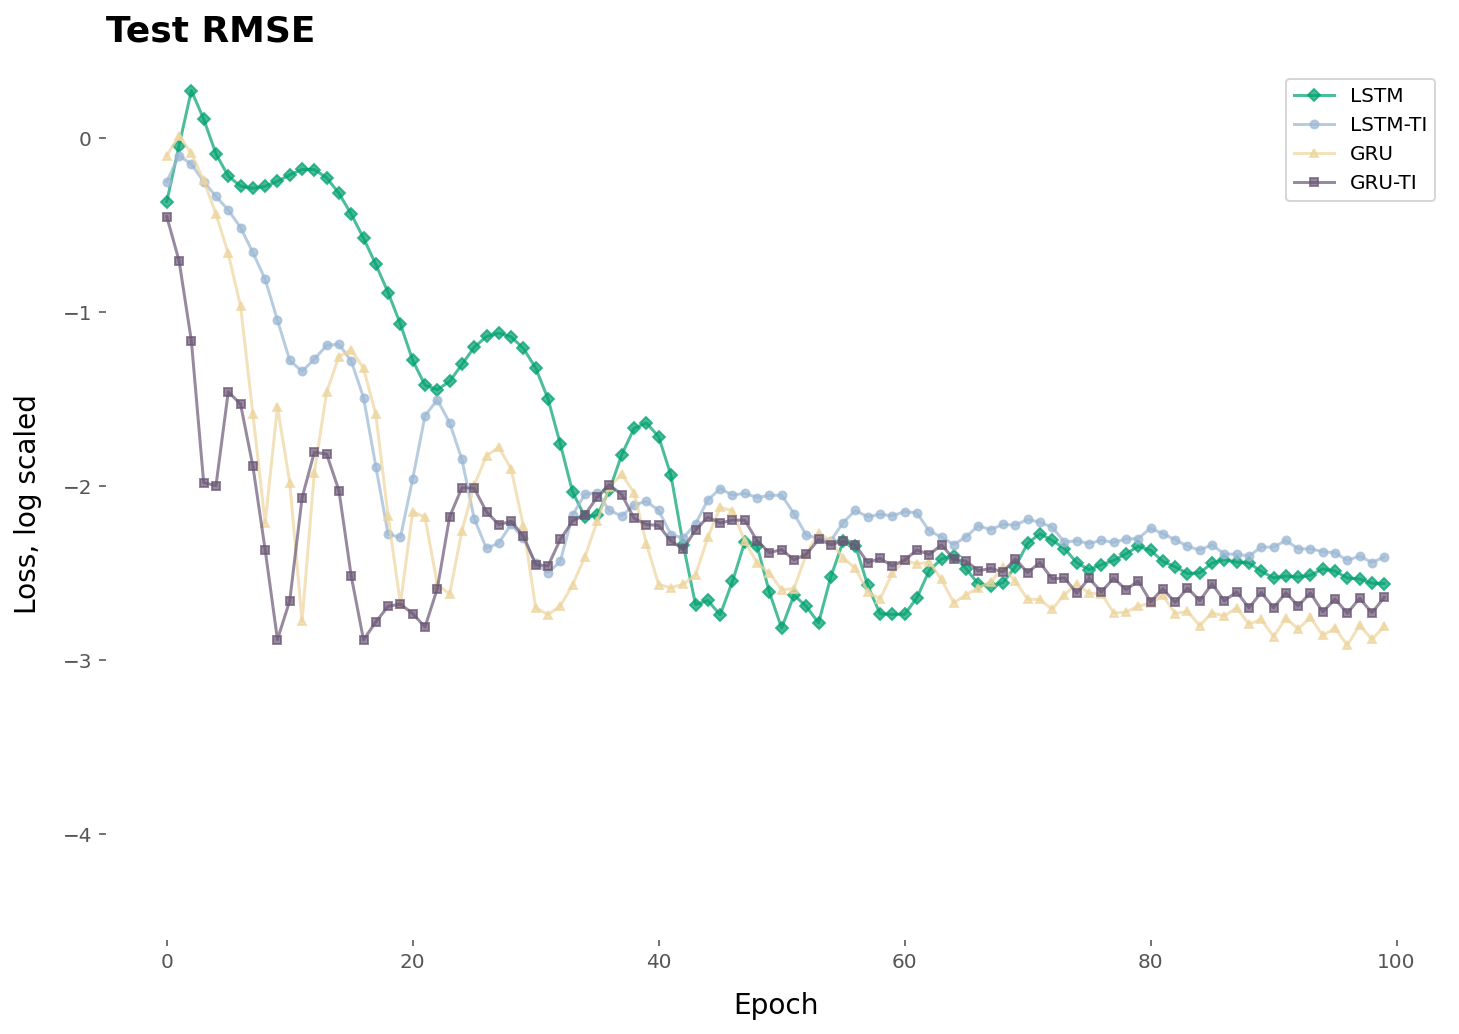

In [65]:
plt.figure(figsize=(12, 8))
plt.title('Test RMSE', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(np.log(test_loss_lstm_without), marker='D', markersize=4, label='LSTM', alpha=0.7, color='#00A170')
plt.plot(np.log(test_loss_lstm_with), marker='o', markersize=4, label='LSTM-TI', alpha=0.7, color='#9BB7D4')
plt.plot(np.log(test_loss_gru_without), marker='^', markersize=4, label='GRU', alpha=0.7, color='#EDD59E')
plt.plot(np.log(test_loss_gru_with), marker='s', markersize=4, label='GRU-TI', alpha=0.7, color='#6B5876')

plt.grid(False)
plt.legend()

plt.ylim(-4.6, 0.4)

plt.ylabel('Loss, log scaled', labelpad=10, fontsize=14)
plt.xlabel('Epoch', labelpad=10, fontsize=14);

## Metaheuristic

### Without Technicals

In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler_without = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_without.fit_transform(data.reshape(-1, 1))).reshape(1, -1).type(torch.Tensor)

In [67]:
batch_windows = data_preproc.unfold(dimension=-1, size=window_size, step=1).reshape(-1, window_size, 1)
    
X_train_without = batch_windows[:train_size, :-1, :]
X_val_without = batch_windows[train_size:train_size+val_size, :-1]
X_test_without = batch_windows[train_size+val_size:, :-1]

# Need predict the next value 
y_train_without = batch_windows[:train_size, -1, :]
y_val_without = batch_windows[train_size:train_size+val_size, -1, :]
y_test_without = batch_windows[train_size+val_size:, -1, :]

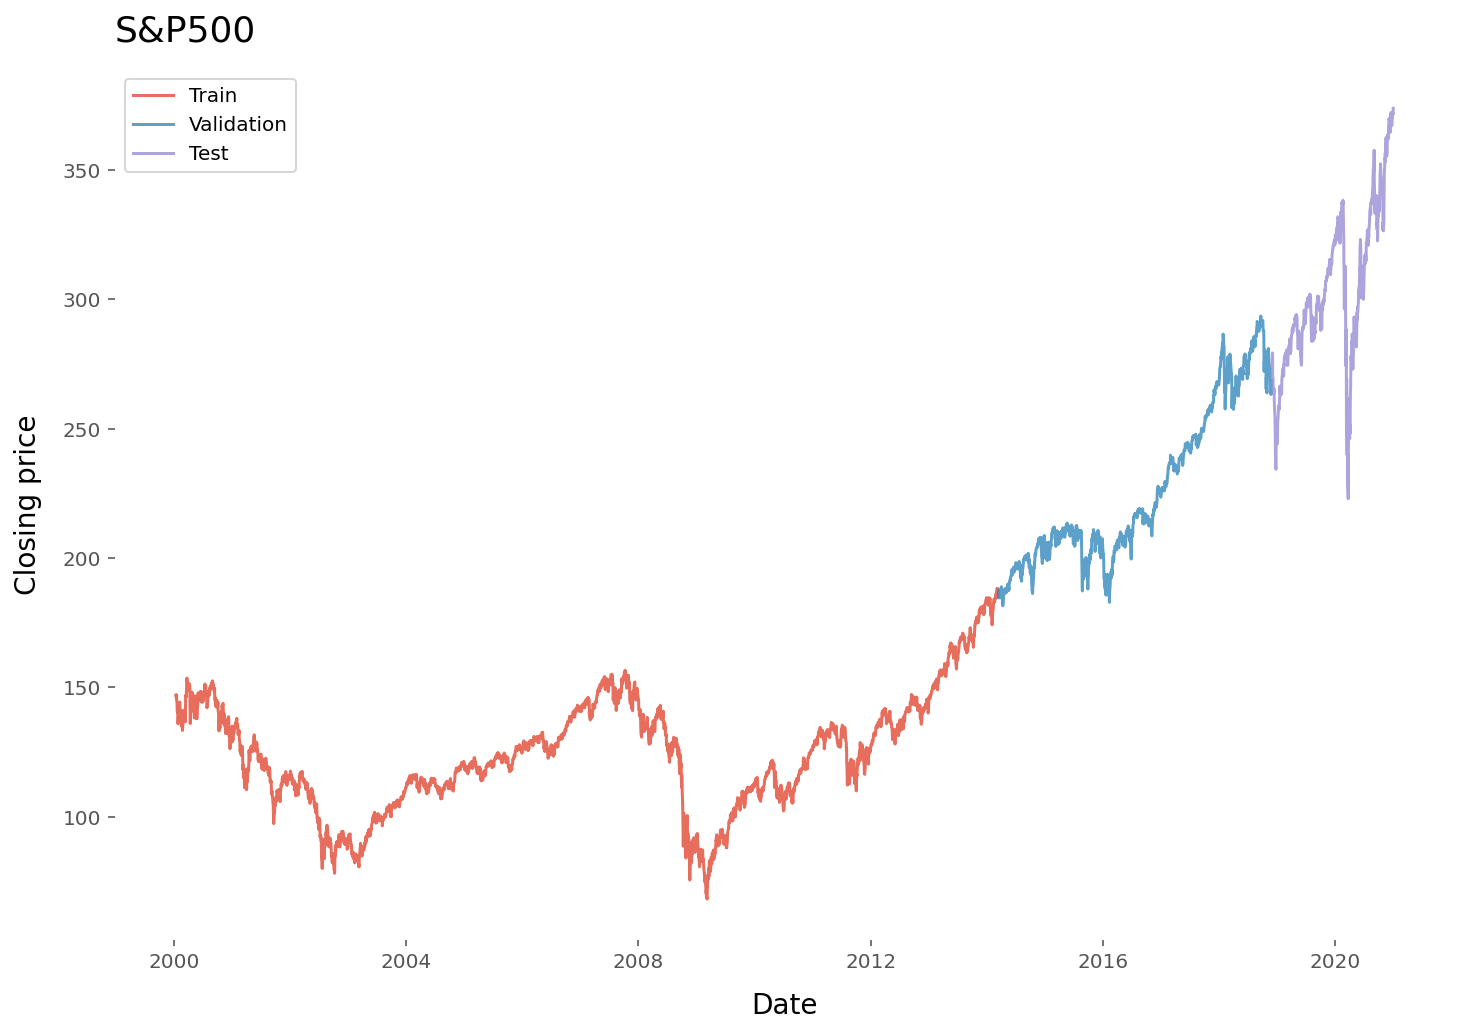

In [68]:
plt.figure(figsize=(12, 8))
plt.title('S&P500', pad=14, fontsize=18, loc='left')

plt.plot(df.index[:train_size], 
         df['Close'][:train_size], 
         label='Train', alpha=0.8)

plt.plot(df.index[train_size:train_size+val_size], 
         df['Close'][train_size:train_size+val_size],
         label='Validation', alpha=0.8)

plt.plot(df.index[train_size+val_size:], 
         df['Close'][train_size+val_size:], 
         label='Test', alpha=0.8)

plt.grid(False)
plt.legend()

plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

### With Technicals

In [69]:
scaler_with = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_with.fit_transform(df)).type(torch.Tensor)
data_preproc_t = data_preproc.transpose(-2, -1)

windows = []

for i in range(data_preproc.shape[1]):
    windows.append(data_preproc_t.unfold(dimension=-1, size=window_size, step=1)[i].reshape(-1, window_size, 1))

batch_windows = torch.cat((windows), dim=2)

X_train_with = batch_windows[:train_size, :-1, :]
X_val_with = batch_windows[train_size:train_size+val_size, :-1]
X_test_with = batch_windows[train_size+val_size:, :-1]

# Need predict the next value 
y_train_with = y_train_without
y_val_with = y_val_without
y_test_with = y_test_without

In [70]:
X_val_with = batch_windows[train_size:train_size+val_size, :-1]

### Genetic Algorithm

#### GA-LSTM

In [82]:
seed_everything()
config = GeneticAlgorithmConfig(ell=150, k=40, num_epochs=10, mutation_rate=0.4)
population = Population(config)

In [83]:
ga_optimizer = GeneticAlgorithm(optimized_block='LSTM',criterion=criterion, 
                                population=population, config=config, 
                                device=device, verbose=True)

Epoch: 10


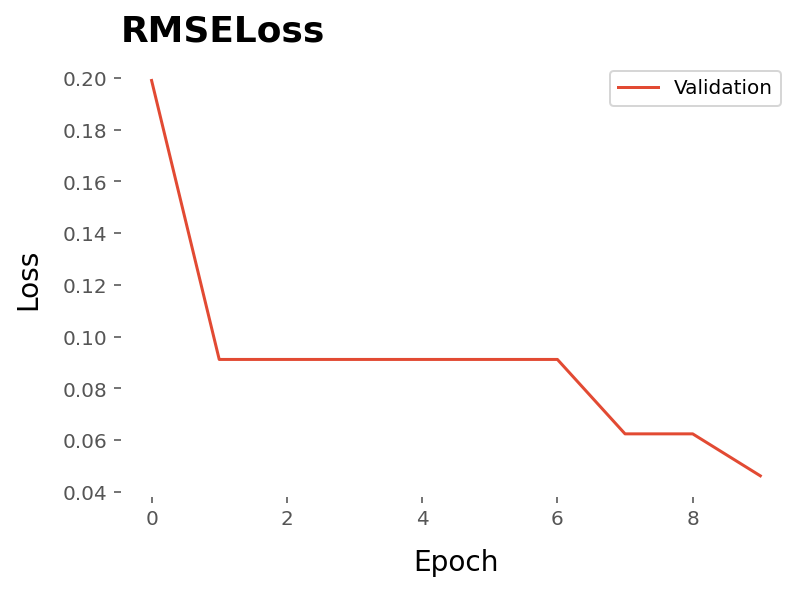

Chromosome #7717166 with the loss of 0.04621 and 251 epochs:
learning_rate = 0.04, num_layers = 2, hidden_size = 8


In [84]:
ga_optimizer.fit(X_val_without, y_val_without)

In [85]:
seed_everything()
ga_lstm_model = LSTM(input_size=X_train_without.shape[2],
                     hidden_size=ga_optimizer.population.best_indivdual.hidden_size,
                     num_layers=ga_optimizer.population.best_indivdual.num_layers)
ga_lstm_model.to(device)

LSTM(
  (lstm): LSTM(1, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [86]:
optimizer = torch.optim.Adam(ga_lstm_model.parameters(), 
                             lr=ga_optimizer.population.best_indivdual.learning_rate)

Epoch: 251


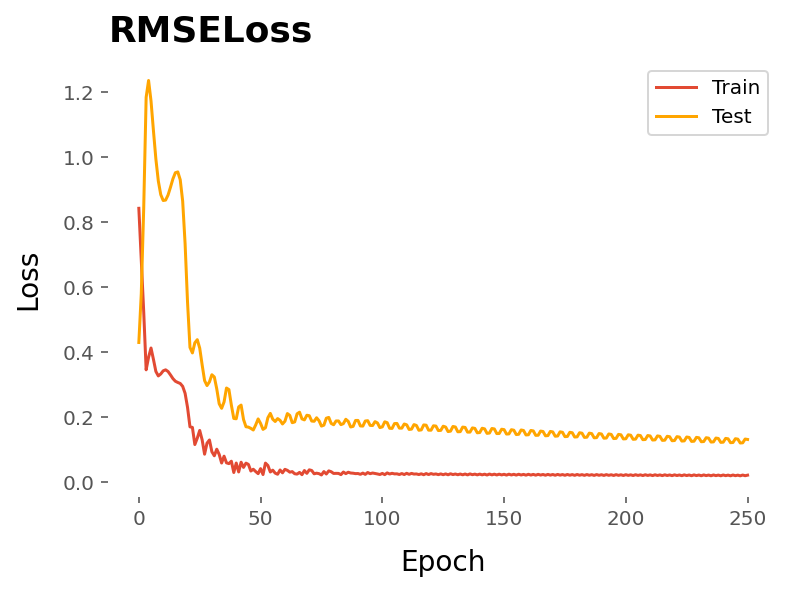

Train loss: 0.02071
Test loss: 0.1305


In [78]:
seed_everything()
train_loss_ga_lstm_without, test_loss_ga_lstm_without = \
    train(ga_lstm_model, criterion, optimizer, device, 
          torch.vstack((X_train_without, X_val_without)), 
          torch.vstack((y_train_without, y_val_without)), 
          X_test_without, y_test_without, n_epochs=ga_optimizer.population.best_indivdual.num_epochs_base)

In [79]:
y_pred_train_ga_lstm_without, y_train, y_pred_test_ga_lstm_without, y_test = \
    get_predictions(ga_lstm_model, scaler_without, 
                    torch.vstack((X_train_without, X_val_without)),
                    torch.vstack((y_train_without, y_val_without)), 
                    X_test_without, y_test_without)

In [80]:
eval_losses(y_pred_train_ga_lstm_without, y_train, 
            y_pred_test_ga_lstm_without, y_test)

Train RMSE = 195.82
Train MAE = 1.177e+04
Train SMAPE = 1.8277

Test RMSE = 451.88
Test MAE = 7403.173
Test SMAPE = 4.5938
R_sq = 0.5544513143915678


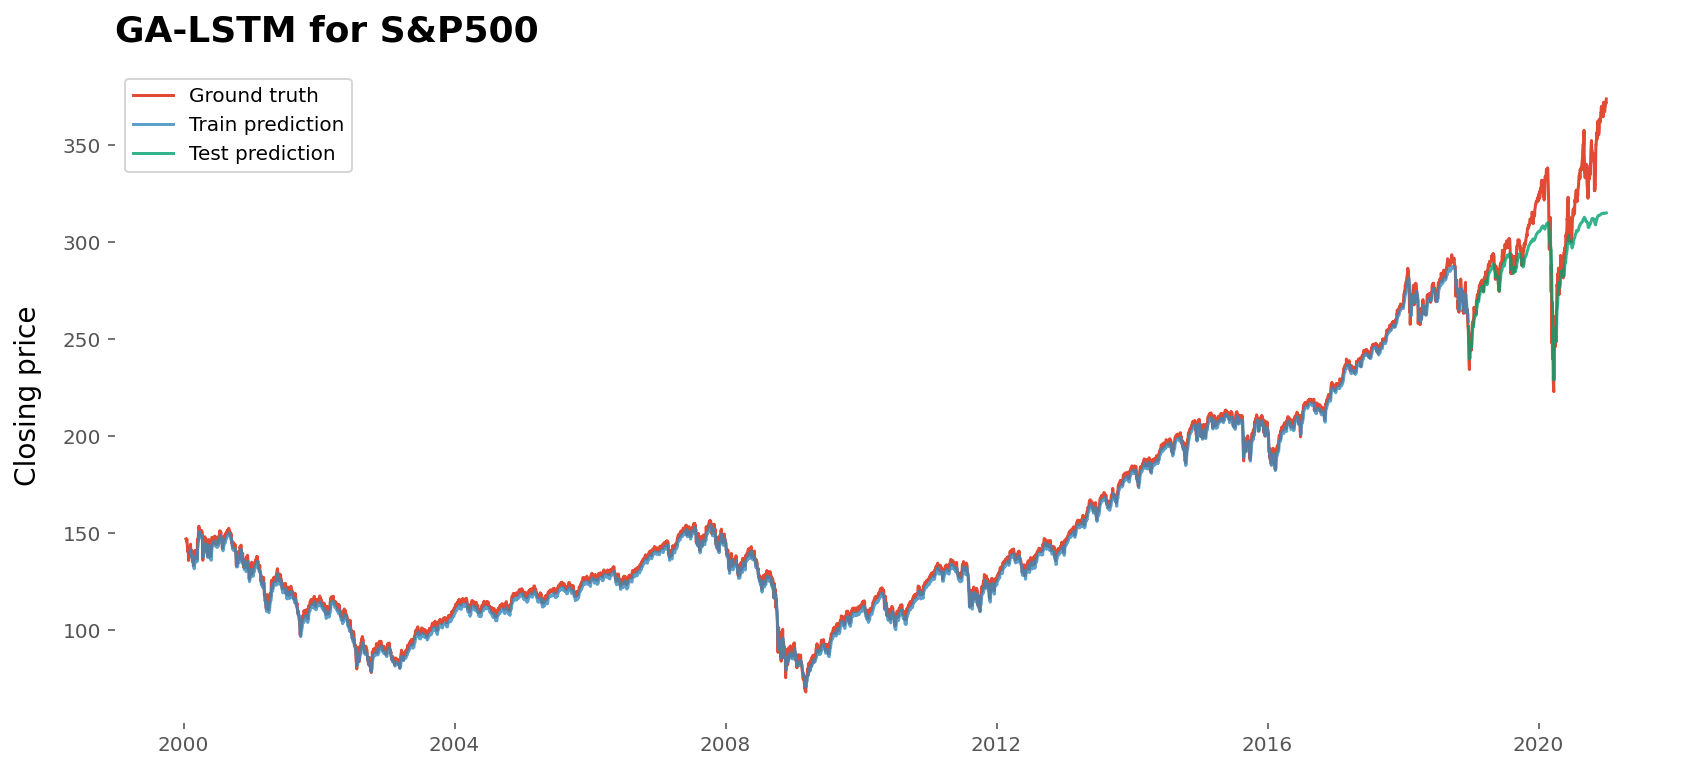

In [81]:
plt.figure(figsize=(14, 6))
plt.title(f'GA-LSTM for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_ga_lstm_without.ravel(), label='Train prediction', alpha=0.8)
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_ga_lstm_without.ravel(), label='Test prediction', color='#00A170', alpha=0.8)

plt.grid(False)
plt.legend()
#plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### GA-LSTM-TI

In [ ]:
seed_everything()
config = GeneticAlgorithmConfig(ell=150, k=40, num_epochs=10, mutation_rate=0.4)
population = Population(config)

In [ ]:
ga_optimizer = GeneticAlgorithm(optimized_block='LSTM',criterion=criterion, 
                                population=population, config=config, 
                                device=device, verbose=True)

In [ ]:
ga_optimizer.fit(X_val_with, y_val_with)

In [ ]:
seed_everything()
ga_lstm_model = LSTM(input_size=X_train_with.shape[2],
                     hidden_size=ga_optimizer.population.best_indivdual.hidden_size,
                     num_layers=ga_optimizer.population.best_indivdual.num_layers)
ga_lstm_model.to(device)

In [ ]:
optimizer = torch.optim.Adam(ga_lstm_model.parameters(), 
                             lr=ga_optimizer.population.best_indivdual.learning_rate)

In [ ]:
seed_everything()
train_loss_ga_lstm_with, test_loss_ga_lstm_with = \
    train(ga_lstm_model, criterion, optimizer, torch.vstack((X_train_with, X_val_with)), torch.vstack((y_train_with, y_val_with)), 
          X_test_with, y_test_with, n_epochs=ga_optimizer.population.best_indivdual.num_epochs_base)

In [ ]:
y_pred_train_ga_lstm_with, y_train, y_pred_test_ga_lstm_with, y_test = \
    get_predictions(ga_lstm_model, scaler_without, 
                    torch.vstack((X_train_with, X_val_with)),
                    torch.vstack((y_train_with, y_val_with)), 
                    X_test_with, y_test_with)

In [ ]:
eval_losses(y_pred_train_ga_lstm_with, y_train, 
            y_pred_test_ga_lstm_with, y_test)

In [ ]:
plt.figure(figsize=(12, 8))
plt.title(f'GA-LSTM for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_ga_lstm_with.ravel(), label='Train prediction')
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_ga_lstm_with.ravel(), label='Test prediction', color='#9BB7D4')

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### GA-GRU

In [ ]:
seed_everything()
config = GeneticAlgorithmConfig(ell=150, k=40, num_epochs=10, mutation_rate=0.4)
population = Population(config)

In [ ]:
ga_optimizer = GeneticAlgorithm(optimized_block='GRU',criterion=criterion, 
                                population=population, config=config, 
                                device=device, verbose=True)

In [ ]:
ga_optimizer.fit(X_val_without, y_val_without)

In [ ]:
seed_everything()
ga_gru_model = GRU(input_size=X_train_without.shape[2],
                    hidden_size=ga_optimizer.population.best_indivdual.hidden_size,
                    num_layers=ga_optimizer.population.best_indivdual.num_layers)
ga_gru_model.to(device)

In [ ]:
optimizer = torch.optim.Adam(ga_gru_model.parameters(), 
                             lr=ga_optimizer.population.best_indivdual.learning_rate)

In [ ]:
seed_everything()
train_loss_ga_gru_without, test_loss_ga_gru_without = \
    train(ga_gru_model, criterion, optimizer, torch.vstack((X_train_without, X_val_without)), torch.vstack((y_train_without, y_val_without)), 
          X_test_without, y_test_without, n_epochs=100)

In [ ]:
y_pred_train_ga_gru_without, y_train, y_pred_test_ga_gru_without, y_test = \
    get_predictions(ga_gru_model, scaler_without, 
                    torch.vstack((X_train_without, X_val_without)),
                    torch.vstack((y_train_without, y_val_without)), 
                    X_test_without, y_test_without)

In [ ]:
eval_losses(y_pred_train_ga_gru_without, y_train, 
            y_pred_test_ga_gru_without, y_test)

In [ ]:
plt.figure(figsize=(12, 8))
plt.title(f'GA-LSTM for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_ga_gru_without.ravel(), label='Train prediction')
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_ga_gru_without.ravel(), label='Test prediction', color='#EDD59E')

plt.legend()
plt.grid(False)
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### GA-GRU-TI

In [ ]:
seed_everything()
config = GeneticAlgorithmConfig(ell=150, k=40, num_epochs=10, mutation_rate=0.4)
population = Population(config)

In [ ]:
ga_optimizer = GeneticAlgorithm(optimized_block='GRU',criterion=criterion, 
                                population=population, config=config, 
                                device=device, verbose=True)

In [ ]:
ga_optimizer.fit(X_val_with, y_val_with)

In [ ]:
seed_everything()
ga_gru_model = GRU(input_size=X_train_with.shape[2],
                    hidden_size=ga_optimizer.population.best_indivdual.hidden_size,
                    num_layers=ga_optimizer.population.best_indivdual.num_layers)
ga_gru_model.to(device)

In [ ]:
optimizer = torch.optim.Adam(ga_gru_model.parameters(), 
                             lr=ga_optimizer.population.best_indivdual.learning_rate)

In [ ]:
seed_everything()
train_loss_ga_gru_with, test_loss_ga_gru_with = \
    train(ga_gru_model, criterion, optimizer, 
          torch.vstack((X_train_with, X_val_with)), 
          torch.vstack((y_train_with, y_val_with)), 
          X_test_with, y_test_with, n_epochs=170)

In [ ]:
y_pred_train_ga_gru_with, y_train, y_pred_test_ga_gru_with, y_test = \
    get_predictions(ga_gru_model, scaler_without, 
                    torch.vstack((X_train_with, X_val_with)),
                    torch.vstack((y_train_with, y_val_with)), 
                    X_test_with, y_test_with)

In [ ]:
eval_losses(y_pred_train_ga_gru_with, y_train, 
            y_pred_test_ga_gru_with, y_test)

In [ ]:
plt.figure(figsize=(12, 8))
plt.title(f'GA-LSTM for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_ga_gru_with.ravel(), label='Train prediction')
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_ga_gru_with.ravel(), label='Test prediction', color='#6B5876')

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Train RMSE', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(np.log(train_loss_ga_lstm_without), marker='D', markersize=4, label='GA-LSTM', alpha=0.7, color='#00A170')
plt.plot(np.log(train_loss_ga_lstm_with), marker='o', markersize=4, label='GA-LSTM-TI', alpha=0.7, color='#9BB7D4')
plt.plot(np.log(train_loss_ga_gru_without), marker='^', markersize=4, label='GA-GRU', alpha=0.7, color='#EDD59E')
plt.plot(np.log(train_loss_ga_gru_with), marker='s', markersize=4, label='GA-GRU-TI', alpha=0.7, color='#6B5876')

plt.grid(False)
plt.legend()

plt.ylabel('Loss, log scaled', labelpad=10, fontsize=14)
plt.xlabel('Epoch', labelpad=10, fontsize=14);

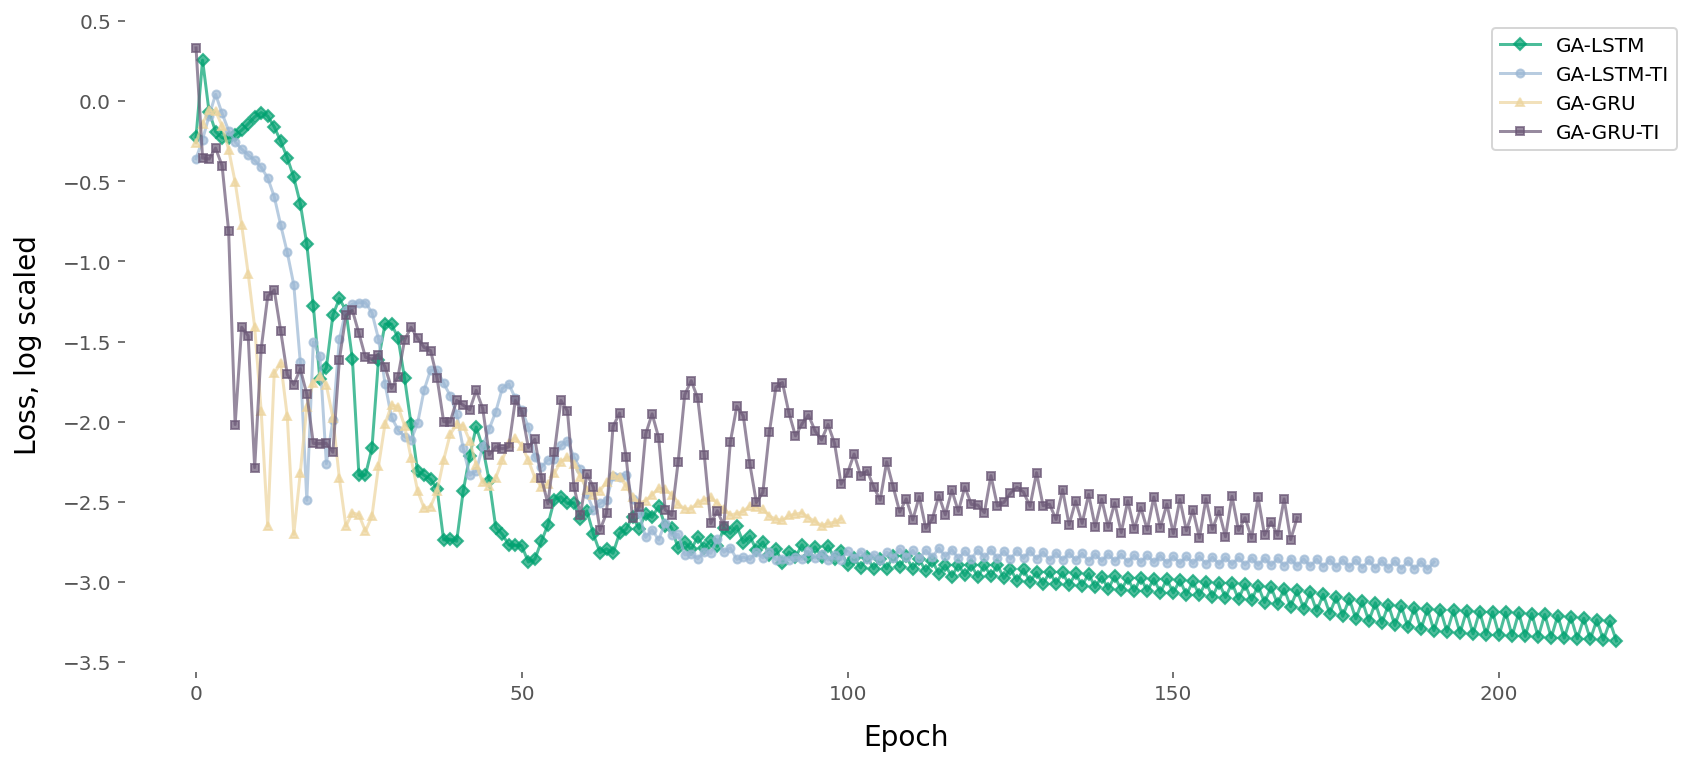

In [ ]:
plt.figure(figsize=(14, 6))
#plt.title('Test RMSE', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(np.log(test_loss_ga_lstm_without), marker='D', markersize=4, label='GA-LSTM', alpha=0.7, color='#00A170')
plt.plot(np.log(test_loss_ga_lstm_with), marker='o', markersize=4, label='GA-LSTM-TI', alpha=0.7, color='#9BB7D4')
plt.plot(np.log(test_loss_ga_gru_without), marker='^', markersize=4, label='GA-GRU', alpha=0.7, color='#EDD59E')
plt.plot(np.log(test_loss_ga_gru_with), marker='s', markersize=4, label='GA-GRU-TI', alpha=0.7, color='#6B5876')

plt.grid(False)
plt.legend()

plt.ylabel('Loss, log scaled', labelpad=10, fontsize=14)
plt.xlabel('Epoch', labelpad=10, fontsize=14);